# PREDICCIÓN DE LAS BOMBAS DEFECTUOSAS EN TANZANIA

El objetivo de esta predicción es afrontar un reto de predicción sobre el estado funcional de bombas de agua en Tanzania, utilizando datos procedentes de la plataforma Taarifa y del Ministerio de Agua de Tanzania (https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/).

El propósito principal es ayudar a optimizar las operaciones de mantenimiento de bombas de agua y asegurar que las comunidades en Tanzania tengan acceso continuado a agua limpia y potable.

# PRIMER MODELO

Se procede a realizar un primer modelo exploratorio. Dicho modelo será lo más básico posible con el objetivo de tener una primera idea y resultado, y a partir de esta primera toma de contacto, mejorarlo con distintos métodos de preprocesamiento y algoritmos.

## 1. PASOS PREVIOS AL ANÁLISIS

### Importación de bibliotecas necesarias (código reutilizado de clase)

In [ ]:
!pip install ydata-profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.5 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=a06fc18dacc06377bc08aa7fc38d4fb804e17e1a3461fcc748daa3abc835f3f8
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


In [ ]:
# ========================
# Lo básico y análisis
# ========================
import pandas as pd
import numpy as np

# ========================
# Visualización
# ========================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pandas.plotting import scatter_matrix

# ========================
# Preprocesado
# ========================
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, scale, label_binarize
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import boxcox

# ========================
# Modelado
# ========================
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# ========================
# Reducción de dimensionalidad
# ========================
from sklearn.decomposition import PCA

# ========================
# Selección de características
# ========================
from sklearn.feature_selection import VarianceThreshold, SelectKBest

# ========================
# Métricas
# ========================
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

# ========================
# Manejo de desbalanceo
# ========================
from imblearn.over_sampling import SMOTE


### Configuración entorno de trabajo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importación de los datasets

In [ ]:
train = '/content/drive/MyDrive/valores_conjunto_entrenamiento.csv'
test = '/content/drive/MyDrive/valores_conjunto_prueba.csv'
etiquetas = '/content/drive/MyDrive/etiquetas_conjunto_entrenamiento.csv'

df1 = pd.read_csv(train)

df2 = pd.read_csv(test)

df3 = pd.read_csv(etiquetas)

### Transformaciones necesarias en los dataframe

Se realiza un merge por la izquierda con la clave común de los dos dataframe con el objetivo de tener en un mismo dataframe los datos de entrenamiento del modelo y la variable objetivo. Para ello, realizamos un merge por la izquierda con la clave en común y generamos un único dataframe.

Asimismo, vemos el balanceo de la variable objetivo y constatamos que tendremos que realizar un balanceo de la misma en los siguientes modelos que realicemos con los distintos métodos aprendidos en clase .

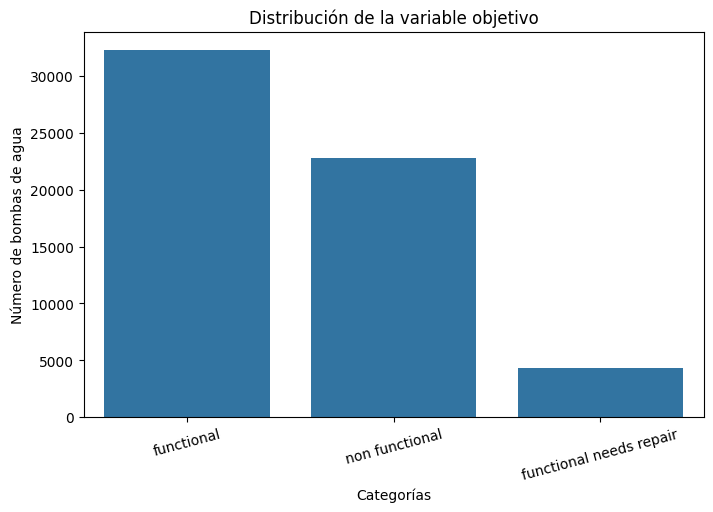

In [ ]:
df_1_3 = pd.merge(df1,df3,how = 'left', on = 'id')

plt.figure(figsize=(8, 5))
sns.countplot(x='status_group', data=df_1_3)
plt.title("Distribución de la variable objetivo")
plt.xlabel("Categorías")
plt.ylabel("Número de bombas de agua")
plt.xticks(rotation=15)
plt.show()

## 2. ANÁLISIS EXPLORATORIO

Se procede a realizar un primer análisis exploratorio rápido de nuestro dataset

En este análisis exploratorio nos centraremos en conocer nuestros datos en el conjunto.

#### 2.1 Primer análisis del dataframe

Se realiza un primer análisis del dataframe y vemos que:
- Tiene una dimensión de 59.400 filas y 41 columnas
- Tiene columnas numéricas y categóricas (nominales, continuas)
- Tiene varias columnas binarias


In [ ]:
df_1_3

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


#### 2.2 Cantidad de valores nulos por variable

Como se puede observar, existen varias variables que tienen una gran cantidad




<ipython-input-7-96242ca9ffed>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='nulos', y='indice', data=df_nulos, palette='Blues_r')


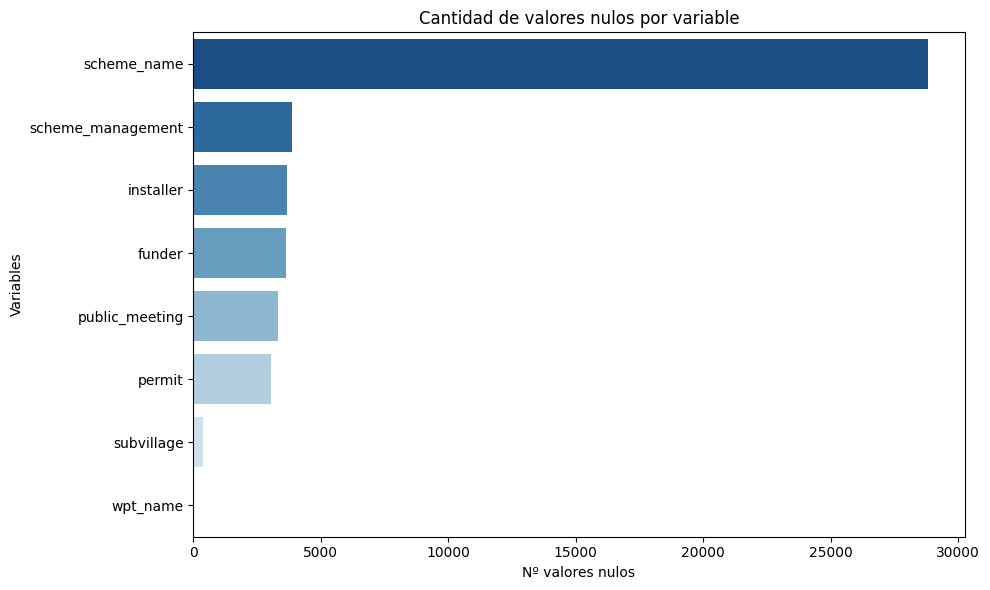

In [ ]:
nulos = df_1_3.isnull().sum()
nulos = nulos[nulos > 0].sort_values(ascending=False)

df_nulos = nulos.reset_index()
df_nulos.columns = ['indice', 'nulos']

plt.figure(figsize=(10, 6))
sns.barplot(x='nulos', y='indice', data=df_nulos, palette='Blues_r')
plt.title("Cantidad de valores nulos por variable")
plt.xlabel("Nº valores nulos")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()


#### 2.3 Tipos de datos

Como se puede observar, existen dos tipos de datos en las variables del dataframe, variables numéricas de tipo integer y float, y variables categóricas de tipo objeto.


<ipython-input-8-f5320a337456>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tipo_dato', y='proporción', data=df_tipo_datos, palette='Blues_r')


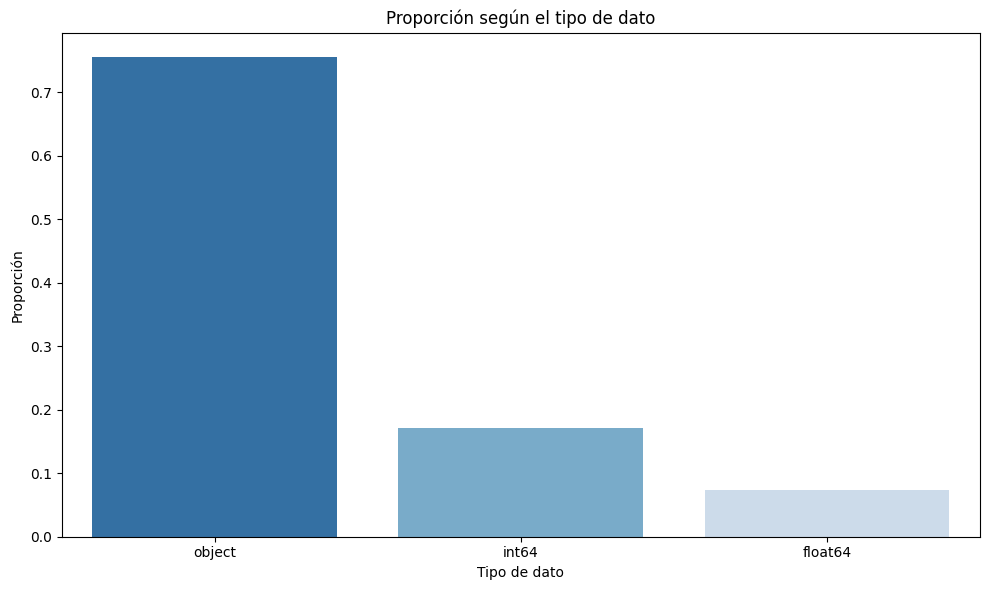

In [ ]:
tipo_datos = df_1_3.dtypes
tipo_datos = tipo_datos.value_counts(normalize = True)

df_tipo_datos = tipo_datos.reset_index()
df_tipo_datos.columns = ['tipo_dato','proporción']

plt.figure(figsize=(10, 6))
sns.barplot(x='tipo_dato', y='proporción', data=df_tipo_datos, palette='Blues_r')
plt.title("Proporción según el tipo de dato")
plt.xlabel("Tipo de dato")
plt.ylabel("Proporción")
plt.tight_layout()
plt.show()


#### 2.4 Estudio de la cardinalidad de las variables

Se realiza un estudio de los valores únicos de cada variable para estudiar la cardinalidad, esto no dará pistas a priori de qué variables tenemos que transformar


<ipython-input-9-9705aa989b35>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='x', y='y', data=df_x, palette='Blues_r')


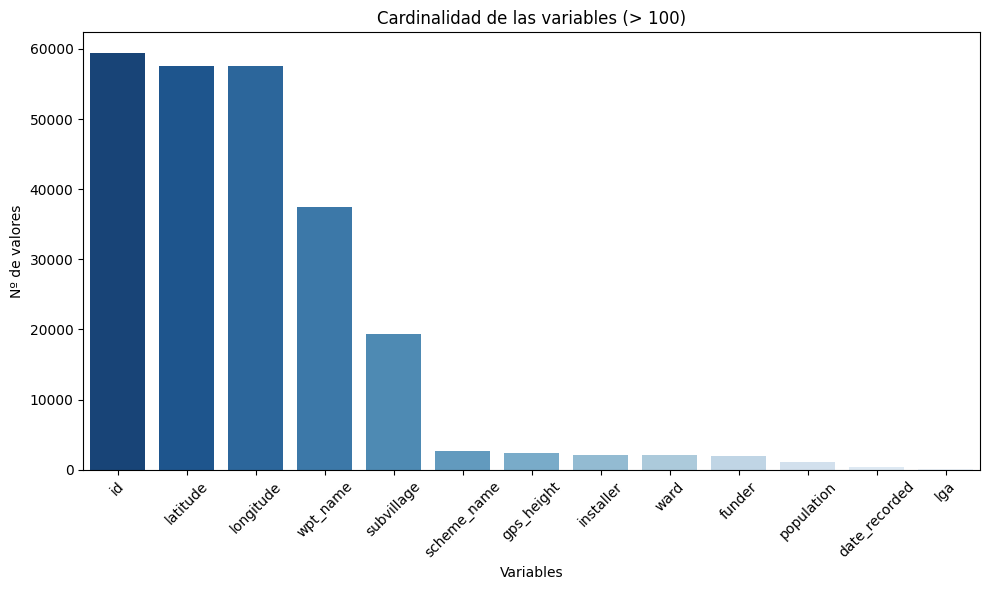

In [ ]:
x = df_1_3.nunique()

df_x = x.reset_index()
df_x.columns = ['x', 'y']

df_x = df_x[df_x['y'] > 100].sort_values(ascending=False, by = 'y')

plt.figure(figsize=(10, 6))
sns.barplot(x='x', y='y', data=df_x, palette='Blues_r')
plt.title("Cardinalidad de las variables (> 100)")
plt.xlabel("Variables")
plt.ylabel("Nº de valores")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. IMPUTACIÓN DE VARIABLES Y AGRUPACIÓN SEGÚN EL TIPO DE DATO

Tras el análisis preliminar que se ha realizado, se procede a imputar aquellas variables categóricas por la moda.

Se ha decidido imputar por este método para el primer modelo realizado, ya que se caracteriza por su simplificidad, rapidez, y teniendo en cuenta que excepto una de las variables, el resto no tiene un número significativo de nulos, es un método que al sustituir por el valor más frecuente, no cambia significativamente la distribución de la variable.

Una vez se realiza esta imputación, se procede a guardar en listas, dependiendo del tipo de dato, a cada una de las variables. Una vez se realiza este paso, se eligen aquellas variables con alta cardinalidad (se determina que aquellas variables con más de 50 valores distintos, cumplen esta condición) y se procede a convertirlas en dummies.

#### 3.1 Imputación variables


In [ ]:
variables_imputar = ['funder', 'installer', 'subvillage', 'public_meeting', 'scheme_management', 'scheme_name', 'permit', 'wpt_name']

for col in variables_imputar:
  moda = df_1_3[col].mode()[0]
  df_1_3[col] = df_1_3[col].fillna(moda)


<ipython-input-81-d13454ff8777>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_1_3[col] = df_1_3[col].fillna(moda)


#### 3.2 Listas según tipo de dato


In [ ]:
lista_binarias = df_1_3[['public_meeting', 'permit']]

In [ ]:
for i in lista_binarias:
    df_1_3[i] = [0 if x == 'no' else 1 for x in df_1_3[i]]

In [ ]:
lista_categoricas = df_1_3.select_dtypes(exclude=[np.number]).columns.tolist()

lista_categoricas = [col for col in lista_categoricas if col not in lista_binarias]

In [ ]:
lista_numericas = df_1_3.select_dtypes(include=[np.number]).columns.tolist()

#### 3.3 Conversión variables con alta cardinalidad a dummies

Antes de realizar esta conversión, se realizan una serie de pasos previos, el primero es excluir la variable objetivo debido a que no procede modificarla. En segundo lugar, se seleccionan únicamente aquellas variables con más de 50 posibles valores (alta cardinalidad) y posteriormente creamos las dummies de estas variables, eliminando las iniciales de estas.

In [ ]:
lista_categoricas_sin_objetivo = [col for col in lista_categoricas if col != 'status_group']

# Selección de variables con alta cardinalidad
lista_alta_cardinalidad = [col for col in lista_categoricas_sin_objetivo if df_1_3[col].nunique() > 50]

for col in lista_alta_cardinalidad:
    freqs = df_1_3[col].value_counts()
    df_1_3[col + '_frecuencia'] = df_1_3[col].map(freqs)

# Se eliminan las columnas originales con alta cardinalidad
df_1_3.drop(columns=lista_alta_cardinalidad, inplace=True)

# Se codifican las variables de baja cardinalidad con dummies
lista_baja_cardinalidad = [col for col in lista_categoricas_sin_objetivo if col not in lista_alta_cardinalidad]

df_1_3 = pd.get_dummies(df_1_3, columns=lista_baja_cardinalidad, drop_first=True)

## 4. PROPUESTA DEL PRIMER MODELO

Una vez se han realizado las transformaciones oportunas en esta primera aproximación, se propone un primer modelo con el algoritmo Random Forest debido a:
- Es un algoritmo versátil para trabajar con outliers, y muchas variables que no siguen una distribución normal.
- Maneja relaciones no lineales y complejas
- No necesita estandarización de las variables

Posteriormente, se realiza la herramienta feature importance para ver qué variables tienen más peso en el modelo. En esta primera aproximación no se procede a la eliminación de aquellas variables que no aportan nada, únicamente se constatan aquellas variables que tienen más importancia y se reflexiona acerca de cómo se puede obtener más valor de estas.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_1_3.drop('status_group',axis=1),
                                                    df_1_3['status_group'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = df_1_3['status_group'])

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### 4.1 Obtenemos las métricas del modelo

Este primer modelo alcanza un accuracy del 81.2%, lo que indica que predice correctamente la clase en 8 de cada 10 casos aproximadamente.

La precisión en el 80.5% fueron correctas, lo cual es bueno pero muestra cierta proporción de falsos positivos.

El recall (81.2%) indica que el modelo identifica correctamente la mayoría de las instancias reales, mostrando pocos falsos negativos.

En cuanto a la matriz de confusión revela que la clase 0 tiene un desempeño fuerte, pero hay confusión considerable entre las clases 0 y 2, y una menor capacidad del modelo para distinguir correctamente la clase 1, posiblemente debido a su menor representación o características más difusas.

In [ ]:
def saca_metricas(y1, y2):
    print('Matriz de Confusión')
    print(confusion_matrix(y1, y2))
    print('Accuracy:', accuracy_score(y1, y2))
    print('Precision:', precision_score(y1, y2, average='weighted'))
    print('Recall:', recall_score(y1, y2, average='weighted'))
    print('F1 Score:', f1_score(y1, y2, average='weighted'))

In [ ]:
saca_metricas(y_test, y_pred)


Matriz de Confusión
[[5771  143  538]
 [ 458  258  147]
 [ 936   56 3573]]
Accuracy: 0.8082491582491582
Precision: 0.8008870974727573
Recall: 0.8082491582491582
F1 Score: 0.799958176972667


In [ ]:
importancia_variables = pd.Series(model.feature_importances_, index=X_train.columns)
importancia_variables.sort_values(ascending = False)


,0
latitude,0.072758
longitude,0.072231
id,0.056145
gps_height,0.041414
subvillage_frecuencia,0.040361
...,...
waterpoint_type_dam,0.000016
waterpoint_type_group_dam,0.000013
extraction_type_other - mkulima/shinyanga,0.000005
public_meeting,0.000000


### 4.2 Transformaciones realizadas en el archivo train a test

Realizamos las mismas transformaciones que hemos realizado en el archivo de train a test.

In [ ]:
# Se imputan las columnas con valores perdidos
for col in variables_imputar:
    if col in df2.columns:
        moda = df2[col].mode()[0]
        df2[col] = df2[col].fillna(moda)

# Se codifican las variables binarias
for i in lista_binarias:
    if i in df2.columns:
        df2[i] = [0 if x == 'no' else 1 for x in df2[i]]

# Se crean las nuevas variables por frecuencia
for col in lista_alta_cardinalidad:
    if col in df2.columns and col in freqs:
        df2[col + '_frecuencia'] = df2[col].map(freqs[col]).fillna(1)

# Se eliminan aquellas columnas con alta cardinalidad
df2.drop(columns=[col for col in lista_alta_cardinalidad if col in df2.columns], inplace=True)

# Se crean dummies para las variables correspondientes
cols_dummies = [col for col in lista_baja_cardinalidad if col in df2.columns]
df2 = pd.get_dummies(df2, columns=cols_dummies, drop_first=True)

# Se ajusta el formato de las columnas del archivo train respecto a test
for col in X_train.columns:
    if col not in df2.columns:
        df2[col] = 0

df2 = df2[X_train.columns]


<ipython-input-21-854155c8328b>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2[col] = df2[col].fillna(moda)


In [ ]:
y_pred = model.predict(df2)


In [ ]:
df_predicciones = pd.DataFrame({
    'id': df2['id'],
    'status_group': y_pred
})


In [ ]:
df_predicciones

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


In [ ]:
df_predicciones.to_csv('SubmissionFormat.csv', index = False)

In [ ]:
from google.colab import files
files.download('SubmissionFormat.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# SEGUNDO MODELO (modelo extensos con numerosos cambios y pruebas)

Tras este primer modelo basado en un análisis explotario preliminar y haber obtenido unos resultados aceptables tiempo/esfuerzo, se procede con el segundo modelo.

## 1. ANÁLISIS ESTADÍSTICO PROFUNDO

Se procede a realizar un análisis estadístico más profundo con determinados métodos y con la librería ProfileReport

In [ ]:
df_1_3.describe(include = np.number).round(2)

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.00,59400.00,59400.00,59400.00,59400.00,59400.00,59400.00,59400.00,59400.00,59400.00
mean,37115.13,22.12,668.30,34.08,-5.71,0.01,14.14,4.56,144.45,1300.65
std,21453.13,38.97,693.12,6.57,2.95,0.11,13.09,5.22,219.51,951.62
min,0.00,0.00,-90.00,0.00,-11.65,0.00,1.00,0.00,0.00,0.00
25%,18519.75,0.00,0.00,33.09,-8.54,0.00,5.00,2.00,0.00,0.00
50%,37061.50,0.00,369.00,34.91,-5.02,0.00,12.00,3.00,25.00,1986.00
75%,55656.50,20.00,1319.25,37.18,-3.33,0.00,17.00,5.00,215.00,2004.00
max,74247.00,100.00,2770.00,40.35,-0.00,1.00,60.00,23.00,862.00,2013.00


En este output podemos ver distintas cuestiones claras que nos guiarán en los siguientes pasos:

- El campo "amount_tsh" (cantidad de agua) tiene una media bastante baja en comparación con su máximo. Se denota una fuerte asimetría y podemos intuir que existen numerosos valores iguales a 0.
- El campo "gps_height" (altitud del pozo) tiene valores negativos, lo que nos indica que algo no tiene sentido pues una bomba por debajo del nivel del mar sería en regiones muy concretas como el Mar Muerto o el Gran Cañón, y nuestro análisis se basa en las bombas de agua de Tanzania.
- El campo "longitude/latitude" (longitud/latitud) también muestra valores atípicos, pues no existe ningún punto en Tanzania con una longitud igual a 0, pues eso serían países ubicados en el Meridiano de Greenwich, así como, valores negativos en la latitud
- El campo "poputation" (población) es candidata a tener outliers puesto que existen valores muy dispersos, lo que indica asimetría en las colas.


In [ ]:
df_1_3.describe(exclude = np.number).round(2)

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,59400,55763,55745,59398,59400,59029,59400,59400,59400,56066,...,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,356,1896,2145,37399,9,19287,21,125,2092,2,...,8,6,5,5,10,7,3,7,6,3
top,2011-03-15,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,True,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,572,9084,17402,3563,10248,508,5294,2503,307,51011,...,50818,50818,33186,33186,17021,17021,45794,28522,34625,32259


En este resumen estadístico no vamos a realizar un detalle como anteriormente pues se trata de las variables categóricas y lo más relevante es que existen numerosas variables con altas cardinalidades.

In [ ]:
profile = ProfileReport(df_1_3, title="Reporte de Datos", explorative=True)
profile.to_notebook_iframe()

Gracias a esta librería podemos analizar rápidamente y de manera muy visual todas las estadísticas y relaciones entre variables del dataset.

Además de lo que ya hemos comentando en los primeros pasos, es interesante ver que:
- No existen variables (numéricas) que sigan una distribución normal, por ello, tienen unas colas asimétricas e indica posibles valores atípicos.
- Existen muchas variables que tienen una correlación alta con otras variables del modelo, esto se debe principalmente a aquellas variables que recogen la misma información pero de manera más agrupada.
- Varias variables muy desbalanceadas, estas en principio no nos tendrían que preocupar en exceso, ya que podríamos hacer algún método de agrupación para ayudar al modelo predictivo.
- Numerosas variables con valores perdidos y ceros, que tendremos que ver a través de qué método las imputamos.

Por último, es interesante comentar que existe un patrón de valores perdidos entre dos variables ("funder" e "installer"), cuestión que se estudiará más adelante.


La presencia o no de valores extremos lo podemos ver con distintos métodos como la asimetría o con distintas funciones (reutilizadas de módulos anteriores) para ver dichos outliers de forma clara

In [ ]:
df_1_3.select_dtypes(include=np.number).skew()

,0
id,0.002623
amount_tsh,57.807800
gps_height,0.462402
longitude,-4.191046
latitude,-0.152037
num_private,91.933750
region_code,3.173818
district_code,3.962045
population,12.660714
construction_year,-0.634928


In [ ]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title(f'Histogram - {variable}')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel(f'Q-Q Plot - {variable}')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title(f'Boxplot - {variable}')

    plt.show()

In [ ]:
from scipy import stats

## Función para gestionar outliers
def gestiona_outliers(col,clas = 'check'):
     print(col.name)
     # Condición de asimetría y aplicación de criterio 1 según el caso
     if abs(col.skew()) < 1:
        criterio1 = abs((col-col.mean())/col.std())>3
     else:
        criterio1 = abs((col-col.median())/stats.median_abs_deviation(col))>6

     # Calcular primer cuartil
     q1 = col.quantile(0.25)
     # Calcular tercer cuartil
     q3 = col.quantile(0.75)
     # Calculo de IQR
     IQR=q3-q1
     # Calcular criterio 2 (general para cualquier asimetría)
     criterio2 = (col<(q1 - 3*IQR))|(col>(q3 + 3*IQR))
     lower = col[criterio1&criterio2&(col<q1)].count()/col.dropna().count()
     upper = col[criterio1&criterio2&(col>q3)].count()/col.dropna().count()
     # Salida según el tipo deseado
     if clas == 'check':
            return(lower*100,upper*100,(lower+upper)*100)
     elif clas == 'winsor':
            return(winsorize_with_pandas(col,(lower,upper)))
     elif clas == 'miss':
            print('\n MissingAntes: ' + str(col.isna().sum()))
            col.loc[criterio1&criterio2] = np.nan
            print('MissingDespues: ' + str(col.isna().sum()) +'\n')
            return(col)

In [ ]:
df_1_3.select_dtypes(include=np.number).apply(lambda x: gestiona_outliers(x))

id
amount_tsh
gps_height
longitude
latitude
num_private
region_code
district_code
population
construction_year


,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
0,0.0,0.000000,0.0,3.050505,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1,0.0,18.722222,0.0,0.000000,0.0,1.274411,6.065657,6.392256,3.296296,0.0
2,0.0,18.722222,0.0,3.050505,0.0,1.274411,6.065657,6.392256,3.296296,0.0


Esta función nos permite localizar de manera rápida los outliers en las variables del dataset.

A simple vista, podemos ver que las variables amount_tsh, num_private y population tienen outliers numéricos claros, sin embargo, variables como longitude y construction_year probablemente tengan valores inválidos
pero no exactamente outliers.

Otras variables como region_code y district_code puede considerarse que no tiene relación tratarla como numérica, sino como categórica, pero finalmente se verá que aporta mayor capacidad predictiva al modelo si se deja como numérica.

Otro método, obtenido de Soledad Gali, para ver las distribuciones de las variables y outliers al mismo tiempo es el siguiente método:


Generando diagnóstico para: id


<ipython-input-7-f7c19caf5a43>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


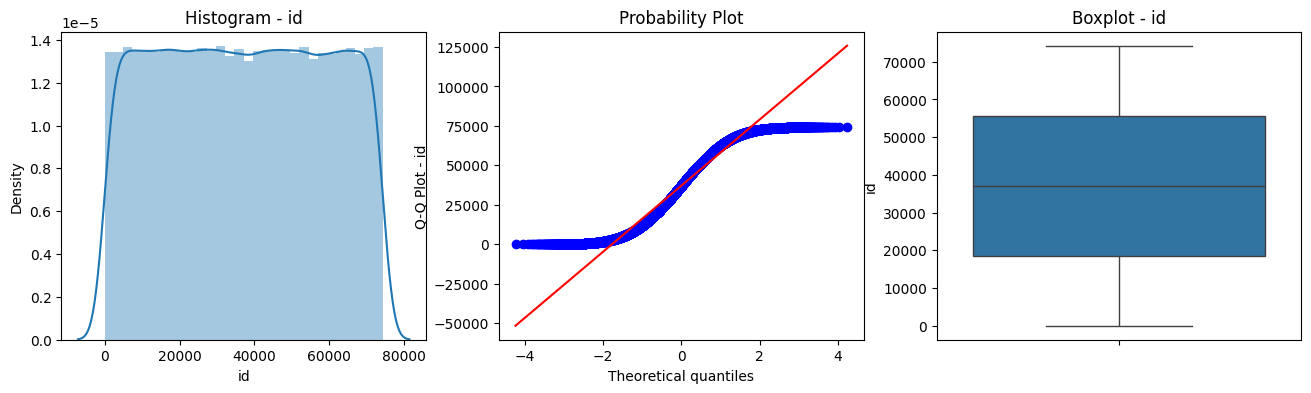


Generando diagnóstico para: amount_tsh


<ipython-input-7-f7c19caf5a43>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


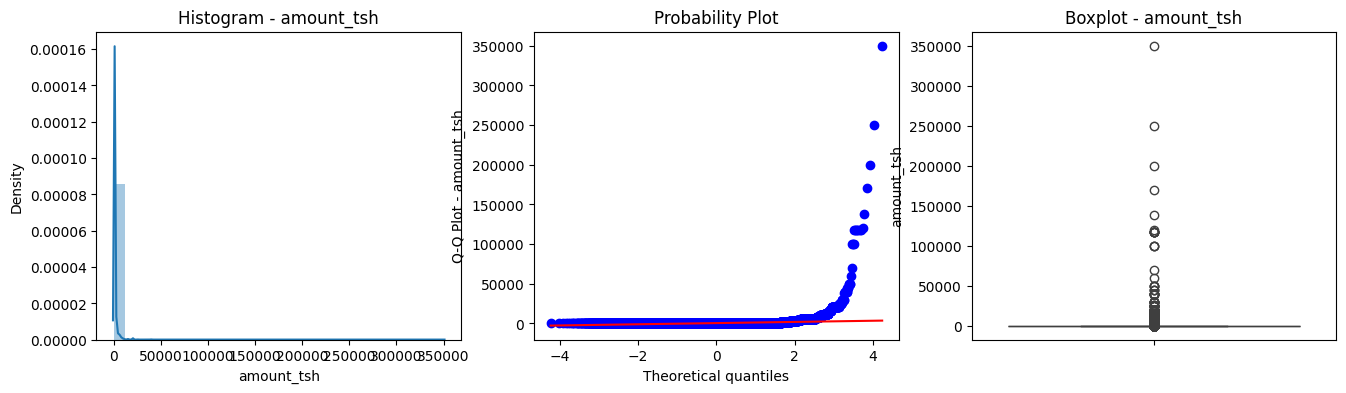


Generando diagnóstico para: gps_height


<ipython-input-7-f7c19caf5a43>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


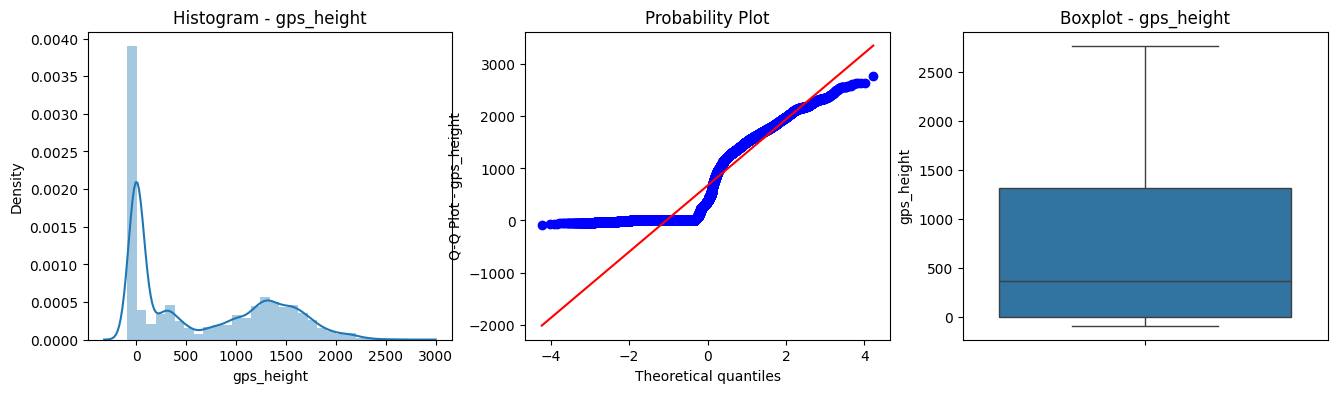


Generando diagnóstico para: longitude


<ipython-input-7-f7c19caf5a43>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


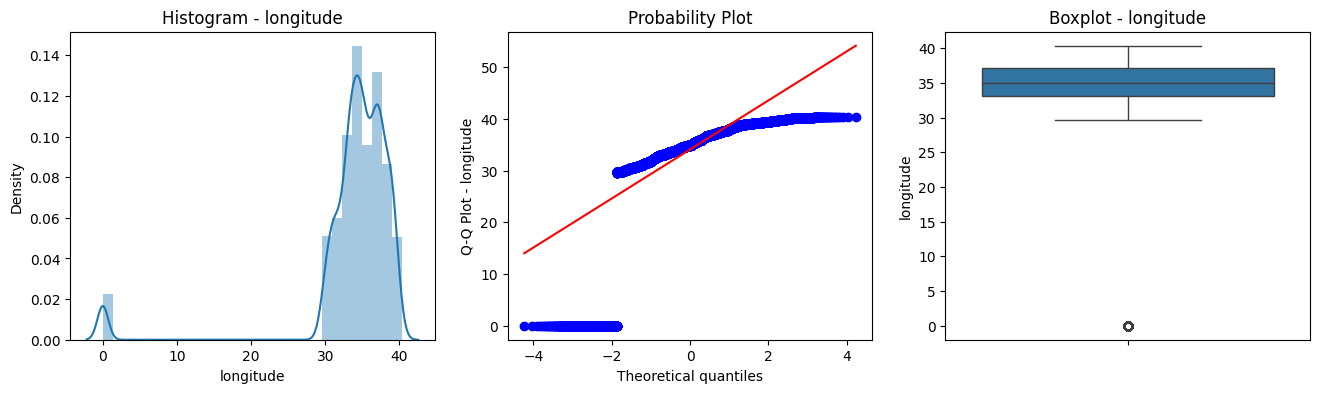


Generando diagnóstico para: latitude


<ipython-input-7-f7c19caf5a43>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


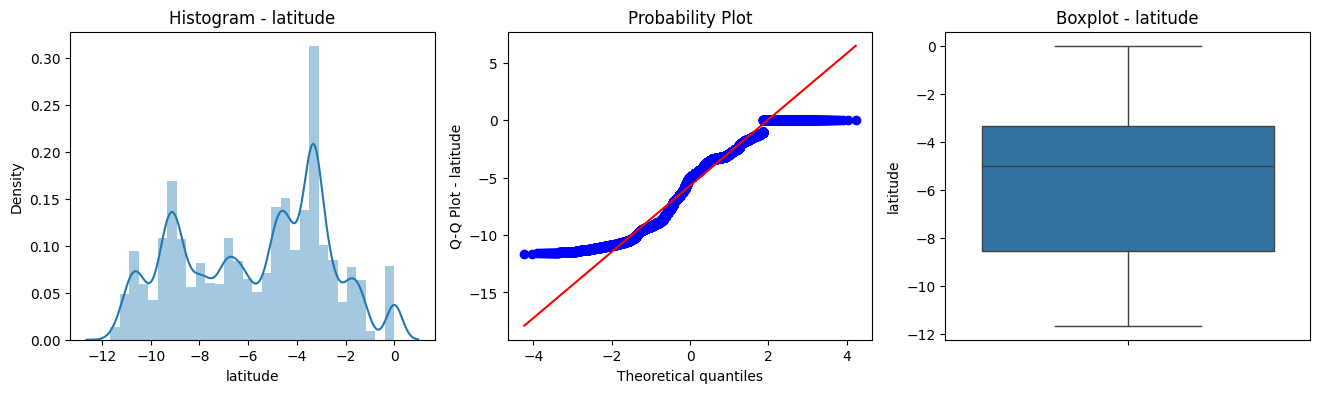


Generando diagnóstico para: num_private


<ipython-input-7-f7c19caf5a43>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


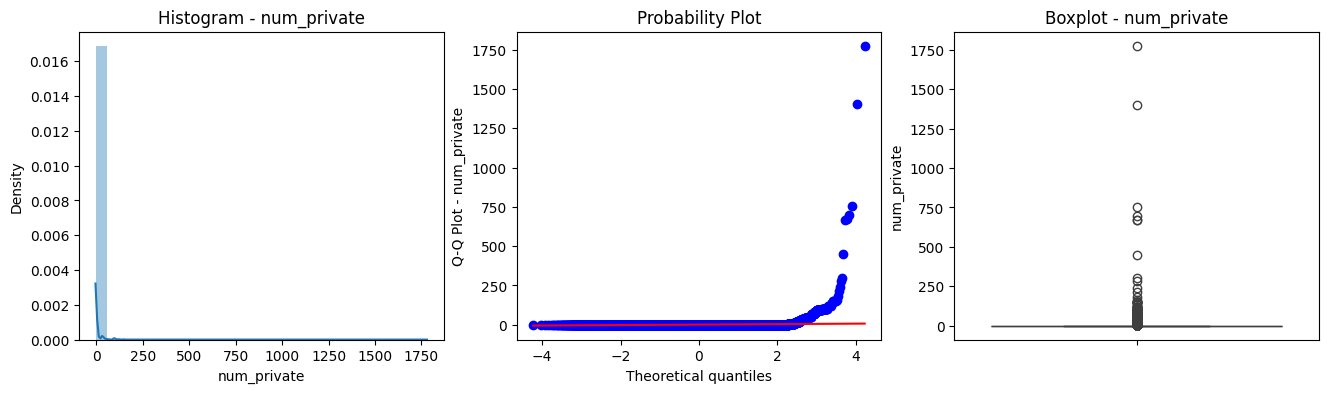


Generando diagnóstico para: region_code


<ipython-input-7-f7c19caf5a43>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


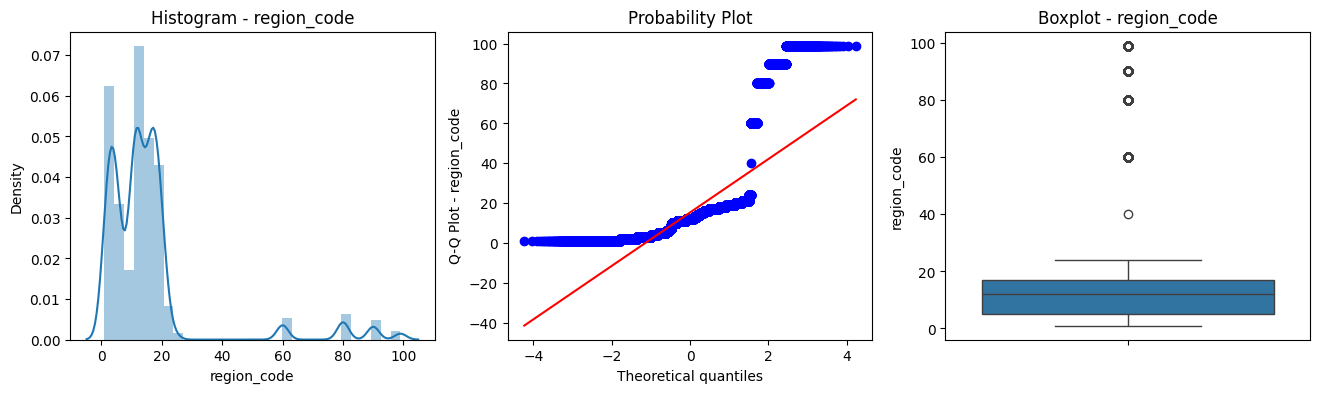


Generando diagnóstico para: district_code


<ipython-input-7-f7c19caf5a43>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


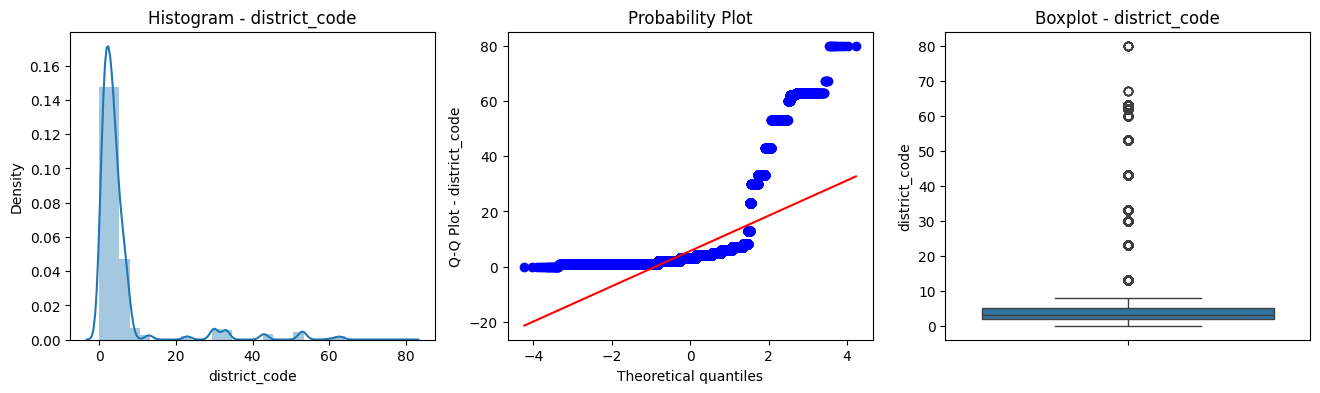


Generando diagnóstico para: population


<ipython-input-7-f7c19caf5a43>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


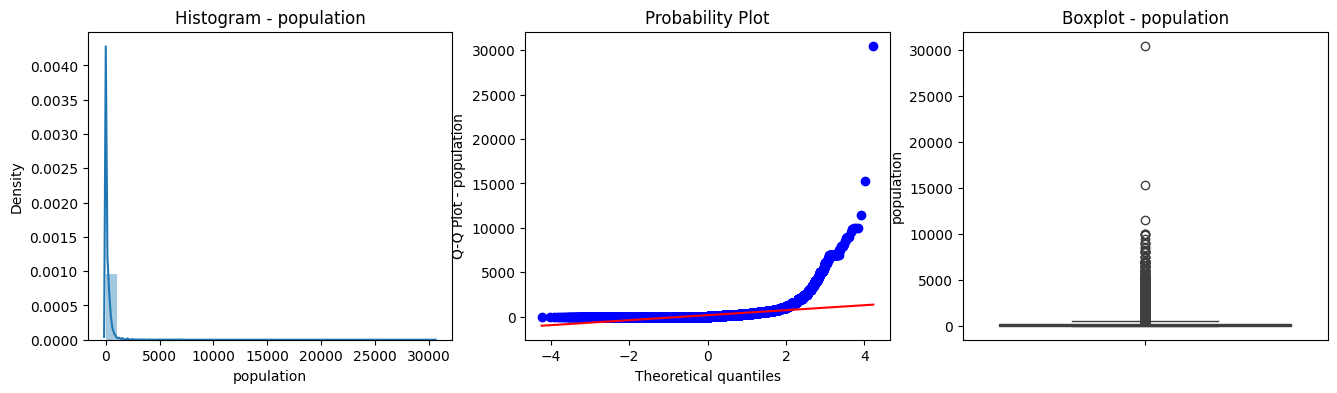


Generando diagnóstico para: construction_year


<ipython-input-7-f7c19caf5a43>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


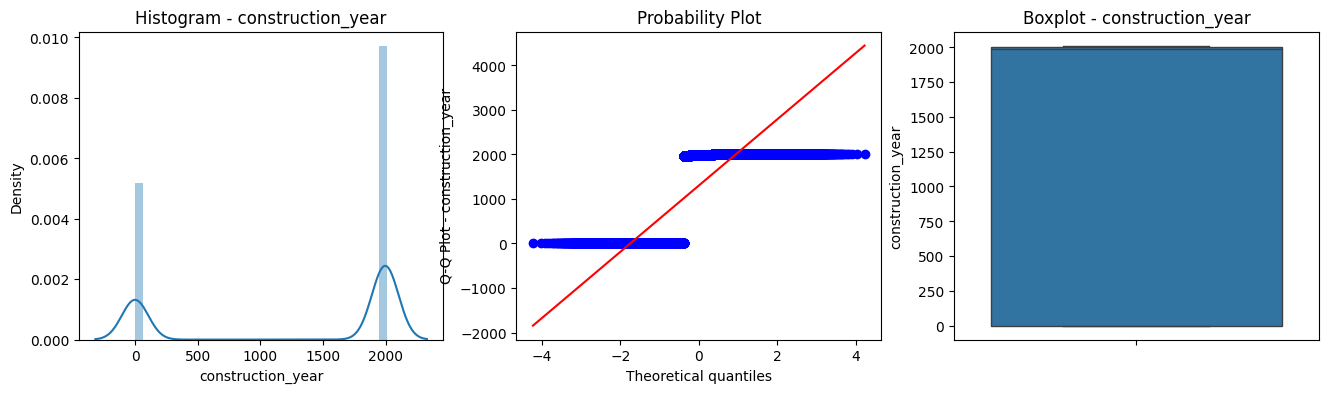

In [ ]:
for var in df_1_3.select_dtypes(include='number').columns:
    print(f'\nGenerando diagnóstico para: {var}')
    diagnostic_plots(df_1_3, var)

Gracias a esta función, podemos confirmar de manera visual la presencia de outliers en varias de nuestras variables.

Antes de proceder a la winsorización (técnica para tratar outliers reemplazando los valores extremos por un percentil límite), convertiremos las variables district_code y region_code en string, debido a que no tiene sentido dejarlas como numéricas, puesto que un código mayor no significa en principio nada. Con el objetivo de validar esta hipótesis se ha ejecutado el modelo manteniendo estas variables como numéricas y tipo objeto, obteniendo mejores resultados en el segundo caso.

-- inciso explicación --

Históricamente se ha demostrado que las regiones del norte están más desarrolladas que las del sur, al igual que el oeste y este respectivamente, sin embargo, dada la dificultad de este análisis por el desconocimiento de la asignación de estos códigos, se realiza una agrupación por regiones en base a las coordenadas.



## 2. CONVERSIÓN Y WINSORIZACIÓN

Como se ha comentado anteriormente, las variables de "district_code" y "region_code" se podrían convertir a string para que el modelo no asuma órdenes en estos códigos, sin embargo, y tras probar de ambas maneras, se constata que dejando las variables como numéricas la capacidad predictiva del modelo es superior.

Asimismo, se procede a winsorizar para reducir el impacto de los outliers en las variables numéricas, reemplazando los valores extremos por los valores en esos percentiles. Se utiliza esta técnica para conservar todos los datos.


In [ ]:
# En caso de que hubiéramos querido convertirlas a string deberíamos seguir este método:

df_1_3['region_code'] = df_1_3['region_code'].astype(str)
df_1_3['district_code'] = df_1_3['district_code'].astype(str)

In [ ]:
## Función manual de winsor con clip+quantile
def winsorize_with_pandas(s, limits):
    """
    s : pd.Series
        Series to winsorize
    limits : tuple of float
        Tuple of the percentages to cut on each side of the array,
        with respect to the number of unmasked data, as floats between 0. and 1
    """
    return s.clip(lower=s.quantile(limits[0], interpolation='lower'),
                  upper=s.quantile(1-limits[1], interpolation='higher'))


In [ ]:
df_1_3[df_1_3.select_dtypes(include=np.number).columns] = \
df_1_3.select_dtypes(include=np.number).apply(lambda col: gestiona_outliers(col, clas='winsor'))

id
amount_tsh
gps_height
longitude
latitude
num_private
region_code
district_code
population
construction_year


Tras esta winsorización, volvemos a ejecutar el código de Soledad Gali para ver qué ha ocurrido con este método de tratamiento de valores extremos


Generando diagnóstico para: id


<ipython-input-7-f7c19caf5a43>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


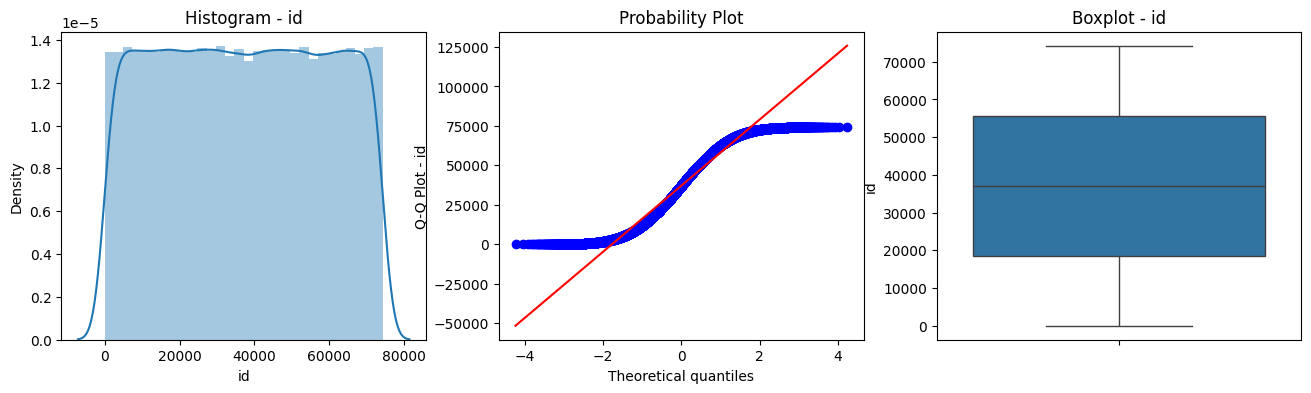


Generando diagnóstico para: amount_tsh


<ipython-input-7-f7c19caf5a43>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


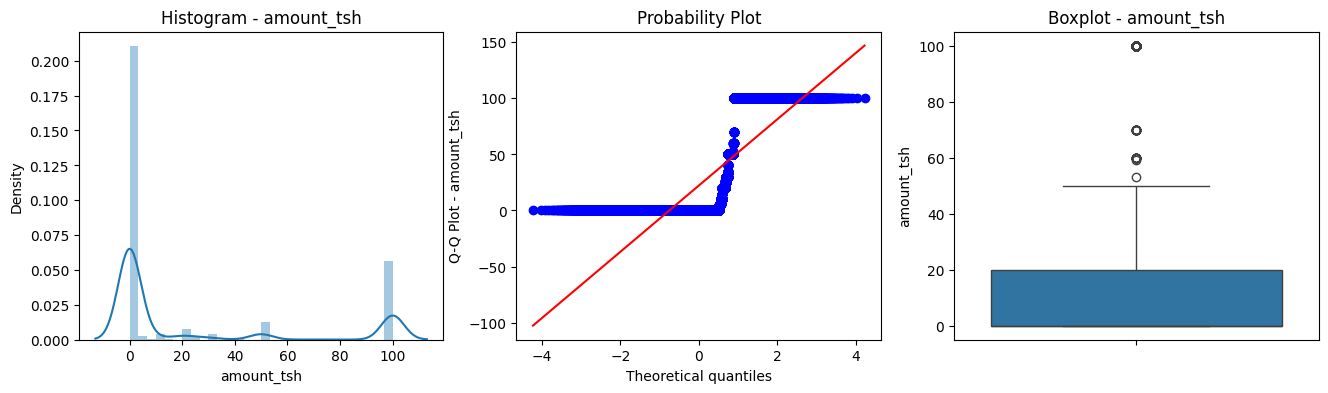


Generando diagnóstico para: gps_height


<ipython-input-7-f7c19caf5a43>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


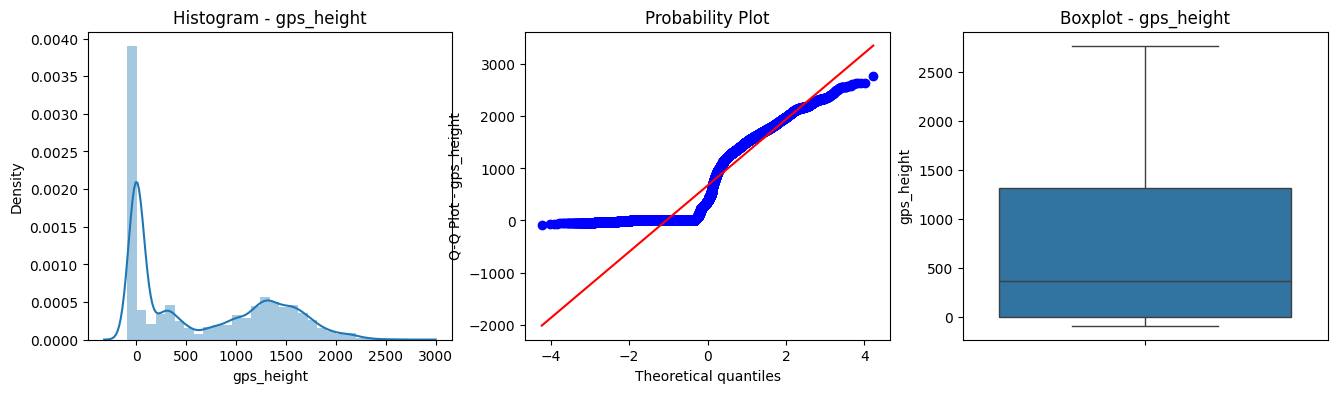


Generando diagnóstico para: longitude


<ipython-input-7-f7c19caf5a43>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


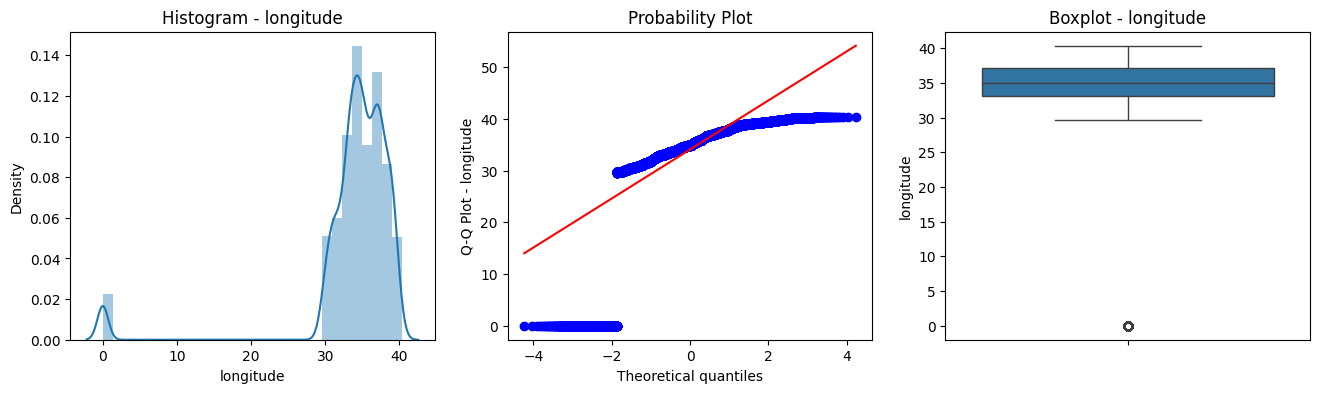


Generando diagnóstico para: latitude


<ipython-input-7-f7c19caf5a43>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


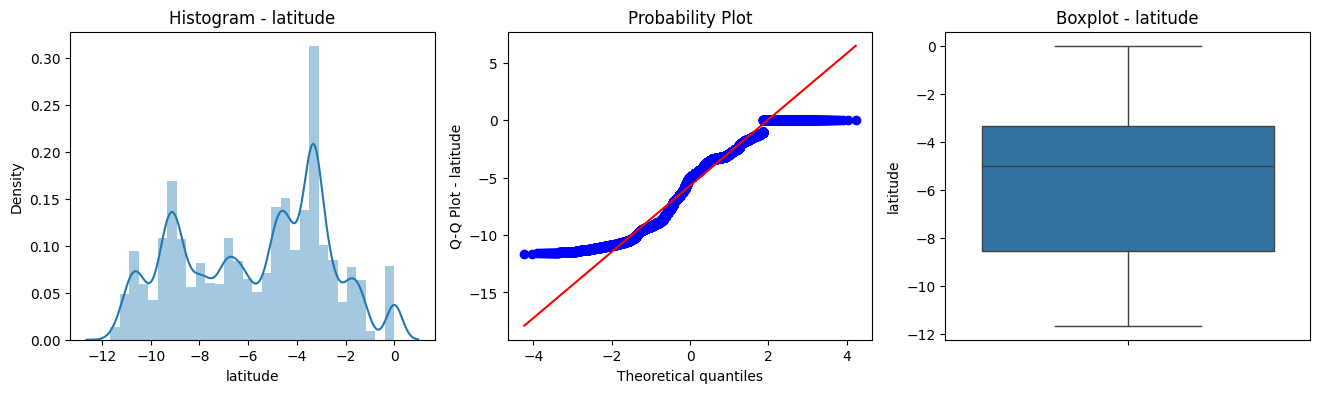


Generando diagnóstico para: num_private


<ipython-input-7-f7c19caf5a43>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


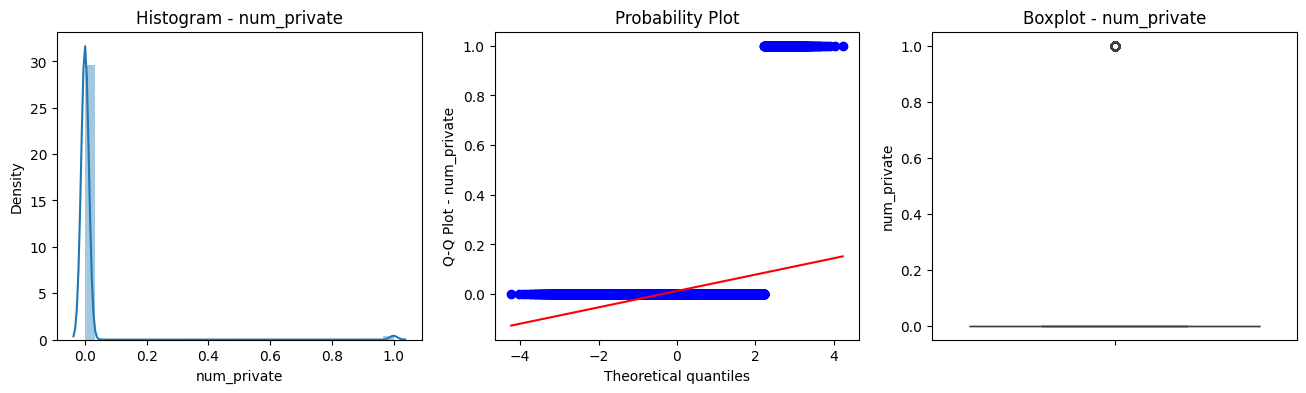


Generando diagnóstico para: region_code


<ipython-input-7-f7c19caf5a43>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


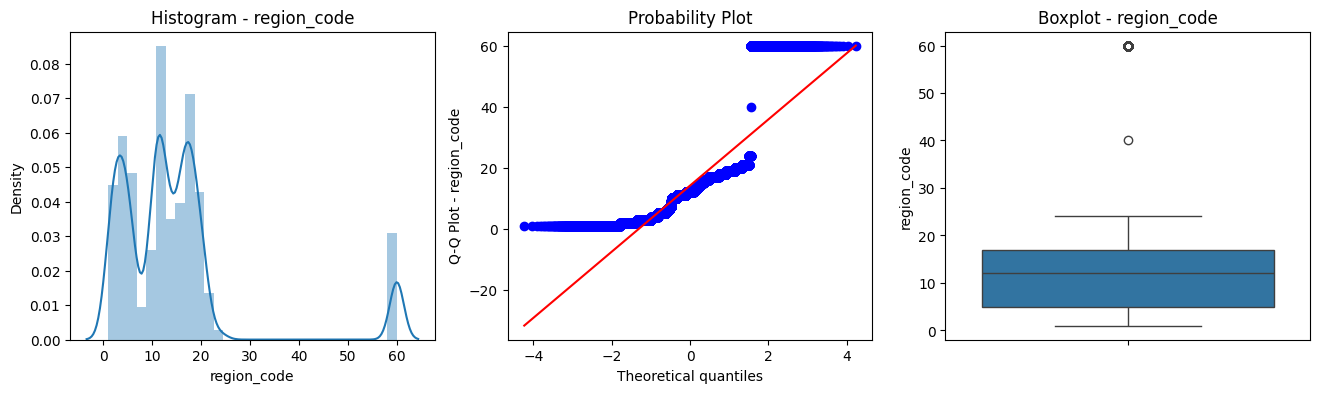


Generando diagnóstico para: district_code


<ipython-input-7-f7c19caf5a43>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


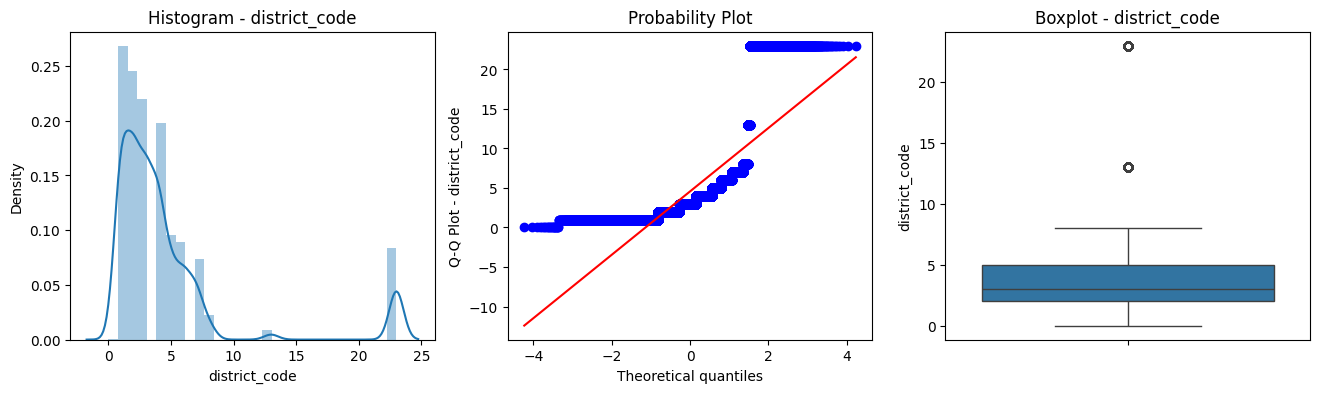


Generando diagnóstico para: population


<ipython-input-7-f7c19caf5a43>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


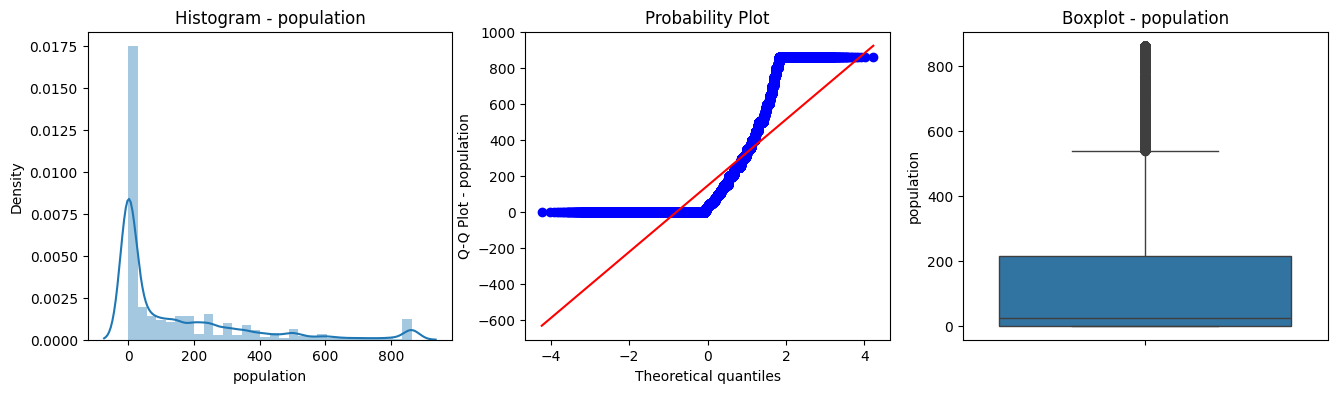


Generando diagnóstico para: construction_year


<ipython-input-7-f7c19caf5a43>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


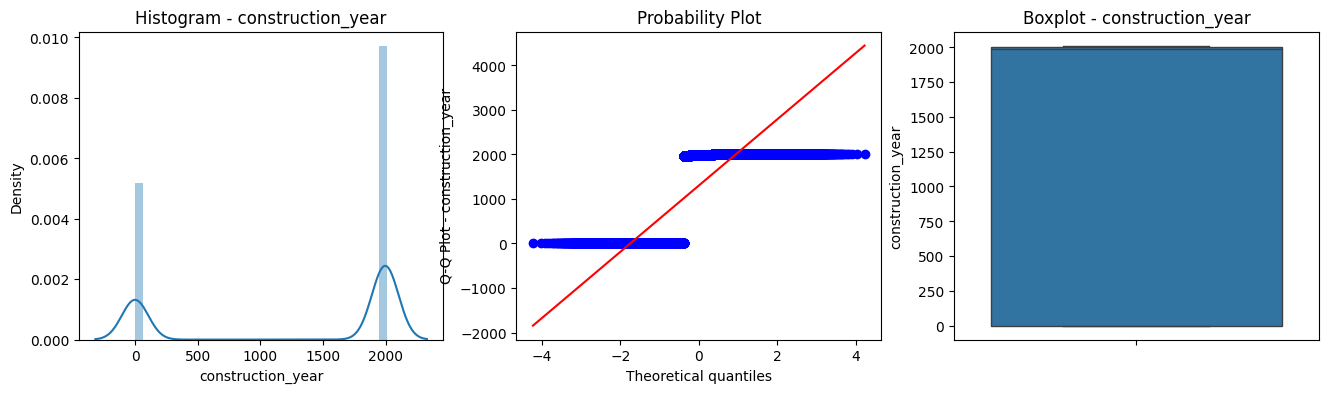

In [ ]:
for var in df_1_3.select_dtypes(include='number').columns:
    print(f'\nGenerando diagnóstico para: {var}')
    diagnostic_plots(df_1_3, var)

Vemos claramente una mejora muy relevante, especialmente en amount_tsh, population y num_private, ya que el número de outliers se ha reducido significativamente, mejorando la calidad de la variable y su posible aportación al modelo de predicción. Asimismo, volvemos a confirmar esto con la asimetría de las variables, destacando únicamente "num_private", variable a la cual se le aplicará una winsorización más extrema.

In [ ]:
df_1_3.select_dtypes(include=np.number).skew()

,0
id,0.002623
amount_tsh,1.381347
gps_height,0.462402
longitude,-4.191046
latitude,-0.152037
num_private,8.688173
region_code,2.442720
district_code,2.771740
population,1.827281
construction_year,-0.634928


## 3. TRANSFORMACIONES VARIABLES NUMÉRICAS

Se procede a analizar las variables numéricas y ver posibilidades de creación de nuevas columnas a partir de las ya existentes, con el objetivo de ayudar a nuestro modelo de predicción.

Como se ha visto anteriormente, las variables de "amount_tsh" y "population" tenían una gran dispersión, y como ya sabemos, la distribución de este tipo de variables en modelos de árboles no ayuda mucho, por ello, se decide aplicar una transformación logaritmica a dichas variables.

Respecto a estas variables, en primeras versiones de este modelo, se optó por no aplicar ninguna transformación, sin embargo, tras ver su asimetría y dispersión de valores, se decidió aplicar esta transformación para favorecer la capacidad predictiva del modelo.

In [ ]:
lista = ['amount_tsh', 'population']

for col in lista:
    df_1_3[f'{col}_log'] = np.log1p(df_1_3[col])

### Amount tsh

Esta variable ha sido una de las que más análisis ha llevado, a pesar de realizar posteriormente distintas transformaciones sencillas. El motivo de esto es debido a que consideraba que la recolección de dato era errónea y no tenía sentido que una bomba de agua que no funcionara, pudiera extraer agua, sin embargo, y pensando bien el funcionamiento de estas bombas, en rara ocasión una bomba de este tipo sería de succión por el coste asociado, y, tras distintas suposiciones, se constató que la mayoría de bombas de agua en Tanzania funcionan por efecto de la gravedad, por ello, se decidió crear varias columnas nuevas, pero manteniendo la original.

In [ ]:
import numpy as np

tramo = [
(df_1_3['amount_tsh'] == 0.00),
(df_1_3['amount_tsh'] > 0.00)
]

valores = [0, 1]

df_1_3['agua_si_no'] = np.select(tramo, valores, default = np.nan).astype('float')

In [ ]:
df_1_3['amount_tsh'].min(), df_1_3['amount_tsh'].max()


(0.0, 100.0)

In [ ]:
df_1_3['amount_tsh_tramo'] = pd.cut(
    df_1_3['amount_tsh'],
    bins=[-0.1, 0, 100, 1000, 10000, 50000, np.inf],
    labels=[0, 1, 2, 3, 4, 5]
).astype('int')

Se procede a eliminar la variable origianal

In [ ]:
df_1_3.drop(columns=['amount_tsh'], inplace=True)

### Gps height

Como se ha analizado anteriormente, se decide realizar una imputación de aquellos valores negativos y ceros, puesto que en las coordenadas de Tanzania es imposible encontrar una bomba por debajo o a nivel del mar.

In [ ]:
df_1_3['gps_height'] = df_1_3['gps_height'].replace({0: np.nan})
df_1_3.loc[df_1_3['gps_height'] <= 0, 'gps_height'] = np.nan

In [ ]:
df_1_3['gps_height_tramo'] = pd.cut(
    df_1_3['gps_height'],
    bins=[-90, 0, 1000, 2000, 3000, np.inf],
    labels=[0,1,2,3,4]
)

### Population

Se apuesta por la creación de una variable nueva que recoja si existe población o no cerca de la bomba de agua y por la creación de otra variable con los distintos tramos de población alrededor de dichas bombas.


In [ ]:
tramo2 = [
(df_1_3['population'] == 0),
(df_1_3['population'] > 0)
]

valores2 = [0,1]

df_1_3['poblacion_si_no'] = np.select(tramo2, valores2, default = np.nan).astype('float')

Se procede a eliminar la variable original

In [ ]:
df_1_3['population'].min(), df_1_3['population'].max()

(0, 862)

In [ ]:
df_1_3['population_tramo'] = pd.cut(
    df_1_3['population'],
    bins=[0, 50, 100, 150, 400, 862, np.inf],
    labels=[0,1,2,3,4,5]
).astype('float')

In [ ]:
df_1_3.drop(columns=['population'], inplace=True)

### Num private

Tras la primera winsorización en la que se reduce significativamente la asimetría de la variable, se decide apostar por una winsorización más fuerte con el objetivo de reducir dicha asimetría, tras realizar estos métodos, se decide eliminarla por no aportar valor suficiente al modelo.


In [ ]:
lower = df_1_3['num_private'].quantile(0.00)
upper = df_1_3['num_private'].quantile(0.99)

df_1_3['num_private_winsor'] = df_1_3['num_private'].clip(lower=lower, upper=upper)


In [ ]:
df_1_3['num_private'].skew()

np.float64(8.688173360337933)

In [ ]:
df_1_3.drop(columns=['num_private', 'num_private_winsor'] , inplace=True)

### Longitude

Como se ha comentado anteriormente, la longitud de Tanzania no es cero en ninguno de sus puntos, por lo tanto, sustituimos dichos valores por la media de la longitud del resto de puntos.

Asimismo, se crea una variable con las regiones geográficas de Tanzania, en concreto, 4 zonas geográficas: noroeste, noreste, suroeste, sureste, usando las longitudes de cada una de las bombas de agua, permitiendo capturar efectos regionales, como que el norte y oeste tengan un desarrollo mayor al sur y este respectivamente.

Este código se ha realizado con ayuda de la ia, para ello, se le ha facilitado todas las coordenadas del dataset y basándose en estas, ha procedido a dividirlas en distintas regiones siguiendo una lógica geográfica.

Por último, destacar que en pruebas de este modelo, se optó por eliminar esta variable para comprobar si mejoraba la capacidad predictiva del modelo, pero se constató que ayudaba más si se encontraba presente.


In [ ]:
media_longitud_sin_ceros = df_1_3.loc[df_1_3['longitude'] != 0, 'longitude'].mean()
df_1_3.loc[df_1_3['longitude'] == 0, 'longitude'] = media_longitud_sin_ceros

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 1. Función para clasificar en regiones geográficas
def asignar_zona_geografica(lat, lon):
    """
    Clasifica coordenadas de Tanzania en 4 zonas:
    - noroeste
    - noreste
    - suroeste
    - sureste
    Usando mezcla de criterios geográficos y estadísticos.
    """
    if lat > -5.5 and lon <= 35.15:
        return 'noroeste'
    elif lat > -5.5 and lon > 35.15:
        return 'noreste'
    elif lat <= -5.5 and lon <= 35.15:
        return 'suroeste'
    else:
        return 'sureste'

# 2. Aplicar la función al DataFrame
df_1_3['zona_geografica'] = df_1_3.apply(lambda row: asignar_zona_geografica(row['latitude'], row['longitude']), axis=1)

# 3. Aplicar Label Encoding manteniendo la columna original
le = LabelEncoder()
df_1_3['zona_geografica_encoded'] = le.fit_transform(df_1_3['zona_geografica'])

Por último, realizamos una última comprobación de la asimetría de las variables y vemos que son muy aceptables, habiendo reducido significativamente las asimetrías iniciales.

In [ ]:
df_1_3.select_dtypes(include=np.number).skew()

,0
id,0.002623
gps_height,-0.229242
longitude,-0.136916
latitude,-0.152037
region_code,2.442720
district_code,2.771740
construction_year,-0.634928
amount_tsh_log,1.006818
population_log,0.101345
agua_si_no,0.878062


### Latitude

Tras el análisis preliminar de esta variable, se constata que no procede realizar ninguna imputación debido a que los valores son lógicos y no parece haber ningún error.

Asimismo, destacar que en pruebas de este modelo, se optó por eliminar esta variable para comprobar si mejoraba la capacidad predictiva del modelo, pero se constató que ayudaba más si se encontraba presente.

### Proporción de missings

Se decide crear una variable de proporción de missings para ver la proporción de nan en total. Se usa para detectar variables con muchos datos perdidos que podrían requerir imputación o eliminación, ayudando en la limpieza de datos antes del análisis o modelado.

Tras crear esta nueva columna, vemos que existe aproximadamente un 17% de proporción de nan, por lo que es asumible.

In [ ]:
df_1_3['prop_missings'] = df_1_3.apply(lambda x: x.isna().sum()/df_1_3.shape[1]*100,axis=1)

df_1_3.prop_missings.describe()

,prop_missings
count,59400.000000
mean,4.011462
std,3.904684
min,0.000000
25%,0.000000
50%,2.127660
75%,8.510638
max,17.021277


## 4. IMPUTACIÓN VARIABLES NUMÉRICAS

Tras el análisis preliminar y transformaciones realizadas sobre las variables numéricas, se procede a la imputación de dichas variables por distintos métodos.

Es importante destacar que se han realizado distintas pruebas con diferentes métodos de imputación para conocer cuál de ellos ayuda mejor a mi modelo predictivo. Entre estos métodos se encuentra la imputación por media, mediana y vecinos cercanos.

Respecto a estos métodos, comentar que la media y mediana son métodos más sencillos de aplicar, y que funcionan bien en aquellos dataset con menores proporciones de valores perdidos, sin embargo, la imputación por knn es útil porque se baja en registros similares para la estimación de dichos valores, preservando patrones complejos y no lineales que se pierden con los otros métodos de imputación.

Es importante tener en cuenta que en la imputación por knn es necesario desescalar porque las distancias entre puntos son sensibles a la escala.


In [ ]:
# Se separan las variables numéricas y no numéricas
df_num = df_1_3.select_dtypes(include='number')
df_otros = df_1_3.select_dtypes(exclude='number')

# Se imputan las variables numéricas por media
imputer_media = SimpleImputer(strategy='mean')
df_num_imputed = pd.DataFrame(
    imputer_media.fit_transform(df_num),
    columns=df_num.columns,
    index=df_num.index
)

# Se unifican de nuevo los df
df_1_3_imputado = pd.concat([df_num_imputed, df_otros], axis=1)

In [ ]:
# Se separan las variables numéricas y no numéricas
df_num = df_1_3.select_dtypes(include='number')
df_otros = df_1_3.select_dtypes(exclude='number')

# Se imputan las variables numéricas por mediana
imputer_mediana = SimpleImputer(strategy='median')
df_num_imputed = pd.DataFrame(
    imputer_mediana.fit_transform(df_num),
    columns=df_num.columns,
    index=df_num.index
)

# Se unifican de nuevo los df
df_1_3_imputado = pd.concat([df_num_imputed, df_otros], axis=1)


In [ ]:
# Se separan las variables numéricas y no numéricas
df_num = df_1_3.select_dtypes(include='number')
df_otros = df_1_3.select_dtypes(exclude='number')

# Se escalan las variables numéricas
scaler = StandardScaler()
df_num_scaled = pd.DataFrame(
    scaler.fit_transform(df_num),
    columns=df_num.columns,
    index=df_num.index
)

# Se imputa por knn
imputer_knn = KNNImputer(n_neighbors=3)
df_num_imputed_scaled = pd.DataFrame(
    imputer_knn.fit_transform(df_num_scaled),
    columns=df_num.columns,
    index=df_num.index
)

# Se desescalan las variables numéricas ya imputadas
df_num_imputed = pd.DataFrame(
    scaler.inverse_transform(df_num_imputed_scaled),
    columns=df_num.columns,
    index=df_num.index
)

# Se unifican de nuevo los df
df_1_3_imputado = pd.concat([df_num_imputed, df_otros], axis=1)

### V de Cramer

Se reutiliza el código visto en el módulo de minería de datos para ver la mejor transformación de las variables numéricas frente a la variable objetivo, con el fin de medir dichas asociaciones y ayudar al modelo predictivo.

Una vez se ha estudiado estas transformaciones por cada una de las variables, se constata que la asimetría tras estas transformaciones es mayor, lo que provoca una mayor distorsión de la variable, por ello, no se procede con este método.

In [ ]:
# Definimos una función para ver cual es la mejor transformación de las variables
def cramers_v(var1, varObj):

    if not var1.dtypes.name == 'category':
        #bins = min(5,var1.value_counts().count())
        var1 = pd.cut(var1, bins = 5)
    if not varObj.dtypes == 'category': #np.issubdtype(varObj, np.number):
        #bins = min(5,varObj.value_counts().count())
        varObj = pd.cut(varObj, bins = 5)

    data = pd.crosstab(var1, varObj).values
    vCramer = stats.contingency.association(data, method = 'cramer')
    return vCramer

def mejorTransf (vv, target, name=False, tipo = 'cramer', graf=False):

    # Escalado de datos (evitar fallos de tamaño de float64 al hacer exp de número grande..cosas de python)
    vv = pd.Series(scale(vv), name=vv.name)
    # Traslación a valores positivos de la variable (sino falla log y las raíces!)
    vv = vv + abs(min(vv))+0.0001

    min_val = vv.min()
    if min_val <= 0:
        vv += abs(min_val) + 1

    y, lambda_ = boxcox(vv)

    # Definimos y calculamos las transformaciones típicas
    transf = pd.DataFrame({vv.name + '_ident': vv, vv.name + '_log': np.log(vv), vv.name + '_exp': np.exp(vv), vv.name + '_sqrt': np.sqrt(vv),
                         vv.name + '_sqr': np.square(vv), vv.name + '_cuarta': vv**4, vv.name + '_raiz4': vv**(1/4), vv.name + 'boxcox': (np.log(vv) if lambda_ == 0 else (vv ** lambda_ - 1) / lambda_)})

    # Distinguimos caso cramer o caso correlación
    if tipo == 'cramer':
      # Aplicar la función cramers_v a cada transformación frente a la respuesta
      tablaCramer = pd.DataFrame(transf.apply(lambda x: cramers_v(x,target)),columns=['VCramer'])

      # Si queremos gráfico, muestra comparativa entre las posibilidades
      if graf: px.bar(tablaCramer,x=tablaCramer.VCramer,title='Relaciones frente a ' + target.name).update_yaxes(categoryorder="total ascending").show()
      # Identificar mejor transformación
      best = tablaCramer.query('VCramer == VCramer.max()').index
      ser = transf[best[0]].squeeze()

    if tipo == 'cor':
      # Aplicar coeficiente de correlación a cada transformación frente a la respuesta
      tablaCorr = pd.DataFrame(transf.apply(lambda x: np.corrcoef(x,target)[0,1]),columns=['Corr'])
      # Si queremos gráfico, muestra comparativa entre las posibilidades
      if graf: px.bar(tablaCorr,x=tablaCorr.Corr,title='Relaciones frente a ' + target.name).update_yaxes(categoryorder="total ascending").show()
      # identificar mejor transformación
      best = tablaCorr.query('Corr.abs() == Corr.abs().max()').index
      ser = transf[best[0]].squeeze()

    # Aquí distingue si se devuelve la variable transformada o solamente el nombre de la transformación
    if name:
      return(ser.name)
    else:
      return(ser)

Realizamos un mapeo de las categorías de la variable objetivo para evitar errores en la aplicación de la función de V de Cramer.

In [ ]:
df_1_3_imputado['status_group'] = df_1_3_imputado['status_group'].map({
    'functional': 0,
    'non functional': 1,
    'functional needs repair': 2
})

In [ ]:
lista_numericas = df_1_3_imputado.select_dtypes(include=[np.number]).columns.tolist()

for col in lista_numericas:
  print(f"{col}")
  tr = mejorTransf(df_1_3_imputado[col], df_1_3_imputado['status_group'], tipo='cramer', graf=True)
  print(tr.head())
  print(df_1_3_imputado[col].head())

id


0    10.517725
1     0.167429
2     2.558125
3     9.972003
4     0.845837
Name: id_sqr, dtype: float64
0    69572.0
1     8776.0
2    34310.0
3    67743.0
4    19728.0
Name: id, dtype: float64
gps_height


0    1.487009
1    1.503625
2    0.208283
3   -0.528913
4    1.607134
Name: gps_heightboxcox, dtype: float64
0    1390.0
1    1399.0
2     686.0
3     263.0
4    1455.0
Name: gps_height, dtype: float64
longitude


0    1.441030
1    1.408313
2    1.749038
3    1.859724
4    0.770458
Name: longitude_sqrt, dtype: float64
0    34.938093
1    34.698766
2    37.460664
3    38.486161
4    31.130847
Name: longitude, dtype: float64
latitude


0   -0.403170
1    2.032834
2    1.539518
3   -0.906850
4    2.126396
Name: latitudeboxcox, dtype: float64
0    -9.856322
1    -2.147466
2    -3.821329
3   -11.155298
4    -1.825359
Name: latitude, dtype: float64
region_code


0      0.340551
1      4.436995
2      5.447390
3    412.478575
4      2.843703
Name: region_code_cuarta, dtype: float64
0    11.0
1    20.0
2    21.0
3    60.0
4    18.0
Name: region_code, dtype: float64
district_code


0    0.979137
1    0.619309
2    0.875778
3    2.099929
4    0.437975
Name: district_code_sqrt, dtype: float64
0     5.0
1     2.0
2     4.0
3    23.0
4     1.0
Name: district_code, dtype: float64
construction_year


0    2.100745
1    2.112304
2    2.111253
3    2.087084
4    0.000100
Name: construction_year_ident, dtype: float64
0    1999.0
1    2010.0
2    2009.0
3    1986.0
4       0.0
Name: construction_year, dtype: float64
amount_tsh_log


0     0.777808
1   -40.927628
2     0.489499
3   -40.927628
4   -40.927628
Name: amount_tsh_logboxcox, dtype: float64
0    4.615121
1    0.000000
2    3.258097
3    0.000000
4    0.000000
Name: amount_tsh_log, dtype: float64
population_log


0    1.337626
1    1.465000
2    1.450259
3    1.245846
4    0.010000
Name: population_log_sqrt, dtype: float64
0    4.700480
1    5.638355
2    5.525453
3    4.077537
4    0.000000
Name: population_log, dtype: float64
agua_si_no


0    2.184351
1    0.000100
2    2.184351
3    0.000100
4    0.000100
Name: agua_si_no_ident, dtype: float64
0    1.0
1    0.0
2    1.0
3    0.0
4    0.0
Name: agua_si_no, dtype: float64
amount_tsh_tramo


0    2.184351
1    0.000100
2    2.184351
3    0.000100
4    0.000100
Name: amount_tsh_tramo_ident, dtype: float64
0    1.0
1    0.0
2    1.0
3    0.0
4    0.0
Name: amount_tsh_tramo, dtype: float64
poblacion_si_no


0    2.083497
1    2.083497
2    2.083497
3    2.083497
4    0.000100
Name: poblacion_si_no_ident, dtype: float64
0    1.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: poblacion_si_no, dtype: float64
population_tramo


0    1.145335
1    1.402725
2    1.402725
3    0.809905
4    0.010000
Name: population_tramo_sqrt, dtype: float64
0    2.0
1    3.0
2    3.0
3    1.0
4    0.0
Name: population_tramo, dtype: float64
zona_geografica_encoded


0    2.942445
1    0.980882
2    0.000100
3    1.961663
4    0.980882
Name: zona_geografica_encoded_ident, dtype: float64
0    3.0
1    1.0
2    0.0
3    2.0
4    1.0
Name: zona_geografica_encoded, dtype: float64
prop_missings


0   -9.210340
1    0.086093
2   -9.210340
3   -0.606962
4    1.002329
Name: prop_missings_log, dtype: float64
0     0.000000
1     4.255319
2     0.000000
3     2.127660
4    10.638298
Name: prop_missings, dtype: float64
status_group


0    0.000100
1    0.000100
2    0.000100
3    1.592268
4    0.000100
Name: status_group_ident, dtype: float64
0    0
1    0
2    0
3    1
4    0
Name: status_group, dtype: int64


## 5. TRANSFORMACIONES VARIABLES CATEGÓRICAS

Se procede a analizar las variables categóricas y ver posibilidades de creación de nuevas columnas a partir de las ya existentes, con el objetivo de ayudar a nuestro modelo de predicción.

### Date recorded

Se procede a separar la fecha en año, mes y día para facilitar el análisis temporal, permitiendo detectar patrones estacionales, reduciendo la dimensionalidad debido a que se crearán tramos a partir de dichas fechas, aportando valor predictivo al modelo.

In [ ]:
# Se convierte a tipo datatime para que no de problemas
df_1_3_imputado['date_recorded'] = pd.to_datetime(df_1_3_imputado['date_recorded'], errors='coerce')

# Se crean las nuevas columnas
df_1_3_imputado['anio'] = df_1_3_imputado['date_recorded'].dt.year
df_1_3_imputado['mes'] = df_1_3_imputado['date_recorded'].dt.month
df_1_3_imputado['dia'] = df_1_3_imputado['date_recorded'].dt.day


In [ ]:
df_1_3_imputado['anio'] = df_1_3_imputado['anio'].apply(
    lambda x: 0 if x in [2012, 2004, 2002] else x
)

En primer lugar, se agrupan los valores de la variable `mes` en tres rangos, asignándoles etiquetas numéricas 0, 1 y 2 para representar cada cuatrimestre del año. Posteriormente, se añade una categoría adicional (-1) para poder identificar y manejar los valores nulos. Por último, se convierte a tipo integer.

In [ ]:
df_1_3_imputado['mes'] = pd.cut(
    df_1_3_imputado['mes'],
    bins=[0, 4, 8, np.inf],
    labels=[0, 1, 2],
    include_lowest=True
)

df_1_3_imputado['mes'] = df_1_3_imputado['mes'].cat.add_categories(-1).fillna(-1).astype('int')


In [ ]:
df_1_3_imputado['dia'] = pd.cut(
    df_1_3_imputado['dia'],
    bins=[0, 10, 20, np.inf],
    labels=[0, 1, 2],
    include_lowest=True
)

df_1_3_imputado['dia'] = df_1_3_imputado['dia'].cat.add_categories(-1).fillna(-1).astype('int')

### Funder

Se procede a agrupar los valores de funder ya que tiene más de 1800 posibles valores, por ello, definimos una frecuencia mínima de 100 para reducir la alta cardinalidad de la variable, ya que muchas categorías tienen pocos registros y aportan ruido o sobreajuste al modelo.

Con esta agrupación, solo se conservan los funders frecuentes y el resto se agrupa como 'Other', simplificando la codificación y mejora el rendimiento del modelo.

Asimismo, se codifica si el funder de la bomba de agua la realiza el Gobierno de Tanzania o no para capturar posibles relaciones.

In [ ]:
min_freq = 100

# Agrupar funder
funder_counts = df_1_3['funder'].value_counts()
frequent_funders = funder_counts[funder_counts >= min_freq].index
df_1_3['funder'] = df_1_3['funder'].where(df_1_3['funder'].isin(frequent_funders), 'Other')

# Codificación por frecuencia
df_1_3['funder_frecuencia'] = df_1_3['funder'].map(df_1_3['funder'].value_counts())

In [ ]:
tramo2 = [
(df_1_3_imputado['funder'] == 'Government Of Tanzania'),
(df_1_3_imputado['funder'] != 'Government Of Tanzania')
]

valores2 = [0,1]

df_1_3_imputado['fundador_gob_no'] = np.select(tramo2, valores2, default = np.nan).astype('object')

### Installer

Al igual que en la variable funder, se procede a agrupar los valores de installer ya que tiene más de 2100 posibles valores.

In [ ]:
min_freq = 100
installer_counts = df_1_3['installer'].value_counts()
frequent_installers = installer_counts[installer_counts >= min_freq].index
df_1_3['installer'] = df_1_3['installer'].where(df_1_3['installer'].isin(frequent_installers), 'Other')
df_1_3['installer_frecuencia'] = df_1_3['installer'].map(df_1_3['installer'].value_counts())

### Resto de variables categóricas (diferentes agrupaciones)

Respecto a estas variables, y en primeras versiones del modelo, se opta por mantenerlas con el fin de ver la capacidad predictiva del modelo, sin embargo, tras probar únicamente con aquellas que tienen mayor agrupación y tratarlas en función del porcentaje de sus valores, se decide eliminar aquellas que no tenían tantas agrupaciones.


In [ ]:
print(df_1_3['extraction_type_class'].value_counts(normalize = True))
print(df_1_3['management_group'].value_counts(normalize = True))
print(df_1_3['payment_type'].value_counts(normalize = True))
print(df_1_3['quality_group'].value_counts(normalize = True))
print(df_1_3['source_class'].value_counts(normalize = True))
print(df_1_3['waterpoint_type_group'].value_counts(normalize = True))

extraction_type_class
gravity         0.450842
handpump        0.277037
other           0.108249
submersible     0.104024
motorpump       0.050286
rope pump       0.007593
wind-powered    0.001970
Name: proportion, dtype: float64
management_group
user-group    0.883670
commercial    0.061246
parastatal    0.029764
other         0.015875
unknown       0.009444
Name: proportion, dtype: float64
payment_type
never pay     0.426734
per bucket    0.151263
monthly       0.139731
unknown       0.137323
on failure    0.065892
annually      0.061313
other         0.017744
Name: proportion, dtype: float64
quality_group
good        0.855522
salty       0.087458
unknown     0.031582
milky       0.013535
colored     0.008249
fluoride    0.003653
Name: proportion, dtype: float64
source_class
groundwater    0.770943
surface        0.224377
unknown        0.004680
Name: proportion, dtype: float64
waterpoint_type_group
communal standpipe    0.582912
hand pump             0.294411
other                 0

In [ ]:
frecs = df_1_3['extraction_type_class'].value_counts(normalize=True)
df_1_3['extraction_type_group'] = df_1_3['extraction_type_class'].where(frecs >= 0.06, 'other')

In [ ]:
df_1_3['management_group_bin'] = (df_1_3['management_group'] == 'user-group').astype(int)

In [ ]:
frecs = df_1_3['payment_type'].value_counts(normalize=True)
df_1_3['payment_type_group'] = df_1_3['payment_type'].where(frecs >= 0.07, 'other')

In [ ]:
df_1_3['quality_group_bin'] = (df_1_3['quality_group'] == 'good').astype(int)

In [ ]:
df_1_3['source_class_bin'] = (df_1_3['source_class'] == 'groundwater').astype(int)

In [ ]:
frecs = df_1_3['waterpoint_type_group'].value_counts(normalize=True)
df_1_3['waterpoint_type_group_recat'] = df_1_3['waterpoint_type_group'].where(frecs >= 0.05, 'other')

In [ ]:
df_1_3.drop(columns = ['extraction_type', 'extraction_type_group', 'management', 'payment', 'water_quality', 'source', 'source_type', 'waterpoint_type'], inplace = True)

## 6. IMPUTACIÓN VARIABLES CATEGÓRICAS

En esta fase se procede a realizar la imputación y codificación de las variables categóricas de nuestro dataset. Primero, se identifican las variables binarias, es decir, aquellas que solo contienen dos valores únicos, codificándolas con 0 y 1 para que no de error a la hora de realizar el modelo.

Asimismo, se detectan las variables categóricas no numéricas, excluyendo la variable objetivo. Estas variables se dividen en dos grupos según su cardinalidad. Se define un umbral de 50 categorías únicas para definir si tiene una alta cardinalidad o no, y aquellas consideradas con alta cardinalidad, se codifica por frecuencia, es decir, cada valor se reemplaza por el número de veces que aparece en el dataset.

Por otro lado, aquellas variables con baja cardinalidad (< 50 categorías) se transforman mediante codificación one-hot encoding, generando columnas binarias para cada categoría posible, eliminando una de sus columnas para evitar multicolinealidad.

In [ ]:
binarias = [col for col in df_1_3_imputado.columns
            if df_1_3_imputado[col].nunique(dropna=True) == 2]

print("Las variables binarias son:", binarias)

lista_binarias = df_1_3_imputado[binarias]

Las variables binarias son: ['agua_si_no', 'amount_tsh_tramo', 'poblacion_si_no', 'public_meeting', 'permit', 'fundador_gob_no']


In [ ]:
df_1_3_imputado.columns = df_1_3_imputado.columns.str.strip()
lista_binarias = [col for col in lista_binarias if col in df_1_3_imputado.columns]
for col in lista_binarias:
    df_1_3_imputado[col] = df_1_3_imputado[col].apply(lambda x: 0 if x == 'no' else 1)


In [ ]:
lista_categoricas = df_1_3_imputado.select_dtypes(exclude=[np.number]).columns.tolist()

lista_categoricas = [col for col in lista_categoricas if col not in lista_binarias]

In [ ]:
# Se excluye la variable objetivo
lista_categoricas_sin_objetivo = [col for col in lista_categoricas if col != 'status_group' and col in df_1_3_imputado.columns]

# Se seleccionan únicamente aquellas variables con alta cardinalidad
lista_alta_cardinalidad = [col for col in lista_categoricas_sin_objetivo if df_1_3_imputado[col].nunique() > 50]

# Se crean nuevas variables en base a la frecuencia de cada una de las variables
for col in lista_alta_cardinalidad:
    freqs = df_1_3_imputado[col].value_counts()
    df_1_3_imputado[col + '_frecuencia'] = df_1_3_imputado[col].map(freqs)

# Se eliminan las columnas originales de alta cardinalidad
df_1_3_imputado.drop(columns=lista_alta_cardinalidad, inplace=True, errors='ignore')

# Se codifican las columnas con baja cardinalidad usando dummies
lista_baja_cardinalidad = [col for col in lista_categoricas_sin_objetivo if col not in lista_alta_cardinalidad and col in df_1_3_imputado.columns]

df_1_3_imputado = pd.get_dummies(df_1_3_imputado, columns=lista_baja_cardinalidad, drop_first=True)

In [ ]:
# Vemos si hay alguna columna con nan que pueda dar error
cols_con_nan = df_1_3_imputado.columns[df_1_3_imputado.isna().any()].tolist()

# Se imputa cada columna con nan usando su frecuencia mínima
for col in cols_con_nan:
  min_freq = df_1_3_imputado[col].min()
  df_1_3_imputado[col].fillna(min_freq, inplace=True)


<ipython-input-53-0db331f6f1a2>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_1_3_imputado[col].fillna(min_freq, inplace=True)


Por último, vemos que el df final con el que vamos a probar modelos no tiene ningún valor perdido

In [ ]:
X = df_1_3_imputado.drop(columns='status_group')
print(X.isna().sum()[X.isna().sum() > 0])

Series([], dtype: int64)


## 7. IMPORTANCIA DE LAS VARIABLES

Se procede a utilizar la V de Cramer para medir la asociación entre cada variable del dataset y la variable objetivo permitiendo identificar las  variables que tienen mayor relación estadística con la objetivo, lo cual sirve para la selección de variables antes de entrenar nuestro modelo.

Únicamente se grafican las 20 mejores puesto que como existen multitud de variables, la graficación de esta importancia de variables es complicado.

Se puede apreciar claramente que no existen variables con una importancia vital que ayude a la capacidad predictiva del modelo, lo que significa que ninguna variable tiene un gran poder explicativo de manera individualizada.

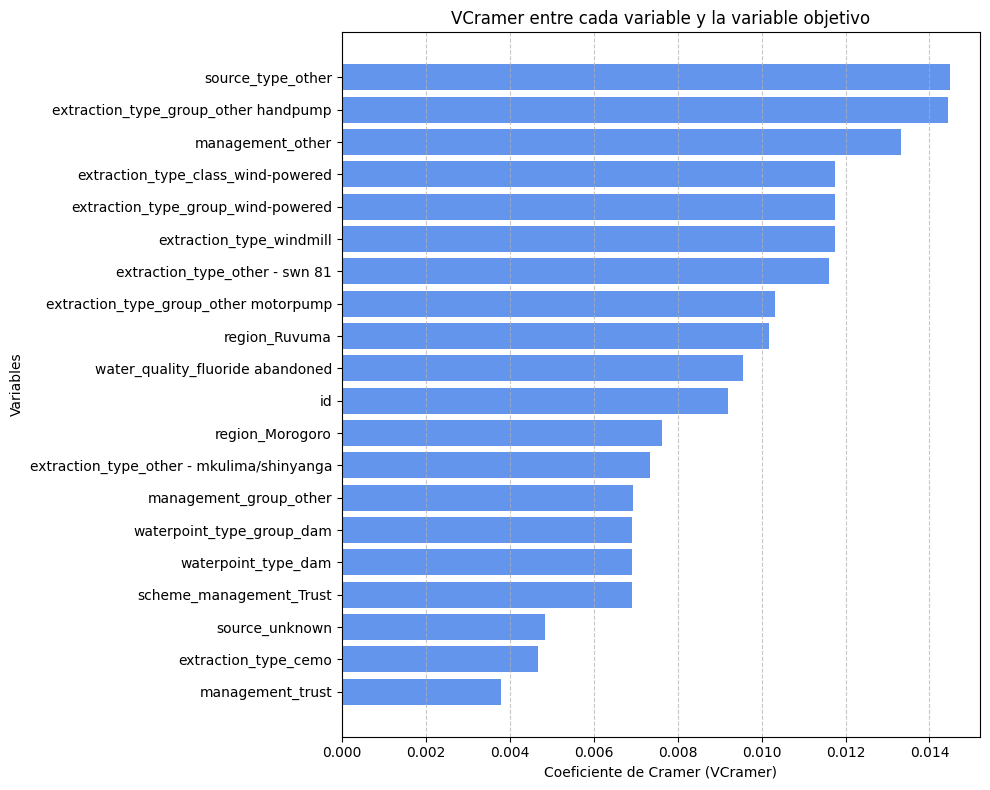

In [ ]:
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Función robusta para calcular V de Cramér
def cramers_v(var1, varObj_numeric):
    try:
        var1 = pd.to_numeric(var1, errors='coerce')
        varObj_numeric = pd.to_numeric(varObj_numeric, errors='coerce')

        if var1.dropna().nunique() > 1:
            var1 = pd.cut(var1, bins=5, duplicates='drop')
        else:
            return np.nan

        if varObj_numeric.dropna().nunique() > 1:
            varObj_numeric = pd.cut(varObj_numeric, bins=5, duplicates='drop')
        else:
            return np.nan

        data = pd.crosstab(var1, varObj_numeric).values
        if data.size == 0:
            return np.nan
        vCramer = stats.contingency.association(data, method='cramer')
        return vCramer
    except:
        return np.nan

# Excluir la variable objetivo del análisis
variables = [col for col in df_1_3_imputado.columns if col != 'status_group']

# Calcular VCramer
tablaCramer = pd.DataFrame({
    col: cramers_v(df_1_3_imputado[col], df_1_3_imputado['status_group'])
    for col in variables
}, index=['VCramer']).T

# Ordenar y graficar
tablaCramer_sorted = tablaCramer.sort_values(by='VCramer', ascending=True).head(20)

plt.figure(figsize=(10, 8))
plt.barh(tablaCramer_sorted.index, tablaCramer_sorted['VCramer'], color='cornflowerblue')
plt.xlabel('Coeficiente de Cramer (VCramer)')
plt.ylabel('Variables')
plt.title('VCramer entre cada variable y la variable objetivo')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 8. MODELOS PROPUESTOS

In [ ]:
def saca_metricas(y1, y2):
    print('Matriz de Confusión (texto)')
    print(confusion_matrix(y1, y2))
    print('Accuracy:', accuracy_score(y1, y2))
    print('Precision:', precision_score(y1, y2, average='weighted'))
    print('Recall:', recall_score(y1, y2, average='weighted'))
    print('F1 Score:', f1_score(y1, y2, average='weighted'))

### 8.1 PCA

Se propone un primer modelo basado en el PCA, el cual es una técnica de reducción de dimensionalidad que transforma las variables originales en un nuevo conjunto de componentes no correlacionados, conservarndo la máxima varianza posible usando el menor número de componentes.

Se aprecia que con 3 componentes mantenemos el 99% de la varianza, lo que indica que la información del dataset está muy concentrada en dos componentes, lo que se traduce es que muchas de las variables son redundantes o están muy correlacionadas (por haber hecho dummies).

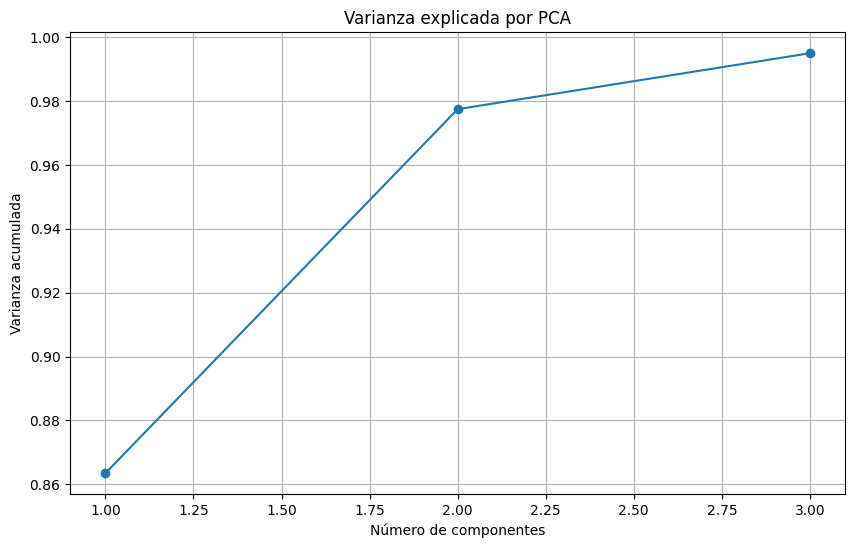

In [ ]:
X = df_1_3_imputado.drop(columns='status_group')
y = df_1_3_imputado['status_group']

pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X)

var_acum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(var_acum) + 1), var_acum, marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('Varianza explicada por PCA')
plt.grid(True)
plt.show()


#### 8.1.1 PCA - REGRESIÓN LOGÍSTICA - BALANCEO

Se propone este modelo porque combina simplicidad e interpretabilidad para datos multiclase. Se pretende reducir la dimensionalidad preservando el 99% de la varianza, lo que en principio mejora la eficiencia y evita la multicolinealidad.

Asimismo, aplicando este balanceo, se permite manejar desbalance en las clases sin técnicas de oversampling.

In [ ]:
pipe_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.99)),
    ('logreg', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        class_weight='balanced',
        max_iter=500
    ))
])

pipe_pca.fit(X_train, y_train)

y_pred = pipe_pca.predict(X_test)

acc     = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall    = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1        = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[[3927  741 1784]
 [ 965 2790  810]
 [ 198  101  564]]
              precision    recall  f1-score   support

           0     0.7715    0.6086    0.6805      6452
           1     0.7682    0.6112    0.6807      4565
           2     0.1786    0.6535    0.2805       863

    accuracy                         0.6129     11880
   macro avg     0.5728    0.6245    0.5472     11880
weighted avg     0.7272    0.6129    0.6515     11880

Accuracy:  0.6129
Precision: 0.5728
Recall:    0.6245
F1 Score:  0.5472


#### 8.1.2 PCA - REGRESIÓN LOGÍSTICA - SMOTE

Se propone una modificación del modelo anterior aplicando SMOTE dentro de la ejecución, gracias a esta opción generamos observaciones sintéticas para equilibrar las clases antes del entrenamiento, lo que mejora la capacidad del modelo para aprender patrones de las minoritarias.

In [ ]:
pipe_smote = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('pca', PCA(n_components=0.99)),
    ('logreg', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=500
    ))
])

pipe_smote.fit(X_train, y_train)

y_pred = pipe_smote.predict(X_test)

acc     = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall    = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1        = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



[[3955  728 1769]
 [ 965 2820  780]
 [ 199  108  556]]
              precision    recall  f1-score   support

           0     0.7726    0.6130    0.6836      6452
           1     0.7713    0.6177    0.6860      4565
           2     0.1791    0.6443    0.2802       863

    accuracy                         0.6171     11880
   macro avg     0.5743    0.6250    0.5500     11880
weighted avg     0.7290    0.6171    0.6552     11880

Accuracy:  0.6171
Precision: 0.5743
Recall:    0.6250
F1 Score:  0.5500


#### 8.1.3 PCA - RANDOM FOREST

Se propone otra modificación del modelo, combinando técnicas para afrontar el desbalance de clases y la alta dimensionalidad. En primer lugar, se aplica SMOTE para equilibrar las clases, mejorando el aprendizaje en casos con minorías, para después aplicar un Random Forest, que permite capturar relaciones complejas entre variables, manteniendo la clase balanceada para reforzar la equidad en la ponderación de errores.



In [ ]:
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('pca', PCA(n_components=0.99)),
    ('rf', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced'
    ))
])

pipe_rf.fit(X_train, y_train)

y_pred = pipe_rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


[[5236  772  444]
 [ 868 3529  168]
 [ 316  145  402]]
              precision    recall  f1-score   support

           0     0.8156    0.8115    0.8135      6452
           1     0.7937    0.7731    0.7833      4565
           2     0.3964    0.4658    0.4283       863

    accuracy                         0.7716     11880
   macro avg     0.6686    0.6835    0.6751     11880
weighted avg     0.7767    0.7716    0.7739     11880

Accuracy:  0.7716
Precision: 0.6686
Recall:    0.6835
F1 Score:  0.6751


### 8.2 LDA - RANDOM FOREST

Se propone un nuevo modelo visto en documentación por internet (https://www.ibm.com/es-es/think/topics/linear-discriminant-analysis) basado en una reducción supervisada de dimensionalidad con Análisis Discriminante Lineal (LDA). Al proyectar los datos en un espacio de 2 componentes que maximizan la separación entre clases, se mejora la capacidad del modelo para distinguir entre ellas. El uso previo de escalado estándar garantiza que las variables tengan el mismo peso en la proyección facilitando una clasificación más eficiente.


In [ ]:
X = df_1_3_imputado.drop(columns='status_group')
y = df_1_3_imputado['status_group']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lda = LDA(n_components=2)
X_lda = lda.fit_transform(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42, stratify=y)

modelo = RandomForestClassifier(random_state=42, class_weight='balanced')
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4))

print("\nResumen de métricas:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Matriz de confusión:
[[5455  830  167]
 [1449 3046   70]
 [ 544  166  153]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.7324    0.8455    0.7849      6452
           1     0.7536    0.6673    0.7078      4565
           2     0.3923    0.1773    0.2442       863

    accuracy                         0.7285     11880
   macro avg     0.6261    0.5633    0.5790     11880
weighted avg     0.7158    0.7285    0.7160     11880


Resumen de métricas:
Accuracy:  0.7285
Precision: 0.6261
Recall:    0.5633
F1 Score:  0.5790


### 8.3 XGBOOST - SMOTE

Se propone un modelo basado en XGBoost con el balanceo de clases mediante SMOTE. Este modelo se configura con hiperparámetros ajustados para mejorar la generalización. Este enfoque busca maximizar la precisión en una tarea multiclase compleja, aprovechando la alta capacidad predictiva y robustez de XGBoost frente a desbalance y ruido.


In [ ]:
X = df_1_3_imputado.drop(columns='status_group')
y = df_1_3_imputado['status_group']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    learning_rate=0.05,
    max_depth=8,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

xgb_model.fit(X_train_bal, y_train_bal)

y_pred = xgb_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("\nResumen de métricas:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[18:28:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




[[5586  528  338]
 [ 979 3463  123]
 [ 386  107  370]]
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      6452
           1       0.85      0.76      0.80      4565
           2       0.45      0.43      0.44       863

    accuracy                           0.79     11880
   macro avg       0.70      0.68      0.69     11880
weighted avg       0.79      0.79      0.79     11880


Resumen de métricas:
Accuracy:  0.7285
Precision: 0.6261
Recall:    0.5633
F1 Score:  0.5790


### 8.4 RANDOM FOREST - SMOTE

Se propone un modelo basado en balanceo con SMOTE pero en vez de XGBOOST con Random Forest, dado que ha sido el mejor modelo hasta ahora visto.

In [ ]:
X = df_1_3_imputado.drop(columns='status_group')
y = df_1_3_imputado['status_group']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

rf_model.fit(X_train_bal, y_train_bal)

y_pred = rf_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4))
print(f"\nAccuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Matriz de confusión:
[[5559  574  319]
 [ 843 3593  129]
 [ 352  121  390]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8231    0.8616    0.8419      6452
           1     0.8379    0.7871    0.8117      4565
           2     0.4654    0.4519    0.4586       863

    accuracy                         0.8032     11880
   macro avg     0.7088    0.7002    0.7040     11880
weighted avg     0.8028    0.8032    0.8024     11880


Accuracy:  0.8032
Precision: 0.7088
Recall:    0.7002
F1 Score:  0.7040


### 8.5 ENSEMBLE RANDOM FOREST Y XGBOOST - SMOTE

Por último, se propone este modelo que evalúa un modelo ensemble para una tarea de clasificación multiclase. Se combinan dos algoritmos potentes Random Forest y XGBoost

Se realiza sin el balanceo de SMOTE, trabajando con el desbalanceo original de los datos.


Matriz de Confusión (texto)
[[5822  492  138]
 [ 958 3560   47]
 [ 452  130  281]]
Accuracy: 0.8133838383838384
Precision: 0.8081230815380952
Recall: 0.8133838383838384
F1 Score: 0.8056364630873856
              precision    recall  f1-score   support

           0     0.8050    0.9024    0.8509      6452
           1     0.8513    0.7798    0.8140      4565
           2     0.6030    0.3256    0.4229       863

    accuracy                         0.8134     11880
   macro avg     0.7531    0.6693    0.6959     11880
weighted avg     0.8081    0.8134    0.8056     11880



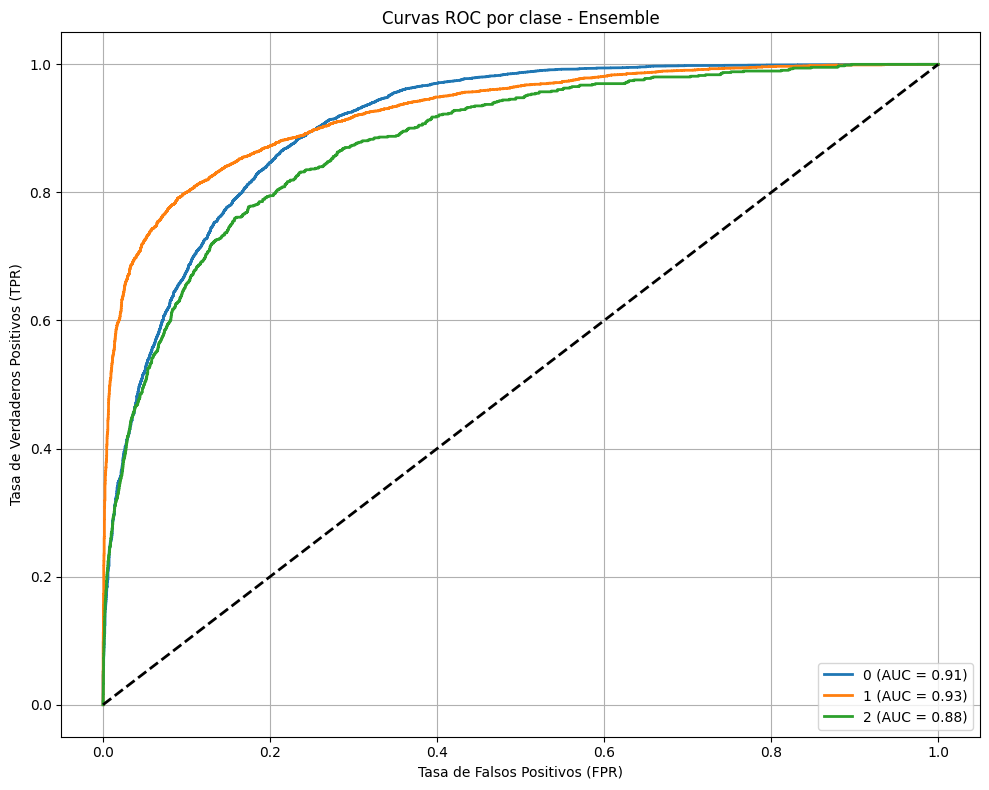

In [ ]:
df = df_1_3_imputado.copy()
X = df.drop(columns=['status_group'])
y = df['status_group']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

clases_ordenadas = sorted(y.unique())
y_test_bin = label_binarize(y_test, classes=clases_ordenadas)

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

xgb_model = XGBClassifier(
    max_depth=10, n_estimators=300, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8,
    use_label_encoder=False, eval_metric='mlogloss',
    random_state=42
)

ensemble = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model)
], voting='soft', n_jobs=-1)

ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)
y_pred_proba = ensemble.predict_proba(X_test)

saca_metricas(y_test, y_pred)
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(10, 8))
for i, clase in enumerate(clases_ordenadas):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{clase} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('Curvas ROC por clase - Ensemble')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Tras el análisis realizado, el modelo alcanzó un accuracy global del 81,3%, lo que indica un buen rendimiento general. Las clases mayoritarias funcional y no funcional obtuvieron métricas sólidas, especialmente la clase funcional, con un recall del 90% y un F1-score de 0.85, lo que sugiere una alta tasa de aciertos. La clase no funcional también fue bien identificada, con un F1-score de 0.81. Sin embargo, el modelo presenta dificultades con la clase minoritaria funcional pero necesita repación, con un recall y un F1-score en comparación con las demás clases, impactando negativamente y viendo la necesidad de seguir buscando otros métodos de balanceo más avanzados.

## 9. TRANSFORMACIONES DE TRAIN APLICADAS A TEST

In [ ]:
df2.select_dtypes(include=np.number).apply(lambda x: gestiona_outliers(x))
df2[df2.select_dtypes(include=np.number).columns] = \
df2.select_dtypes(include=np.number).apply(lambda col: gestiona_outliers(col, clas='winsor'))
lista = ['amount_tsh', 'population']
for col in lista:
    df2[f'{col}_log'] = np.log1p(df2[col])
import numpy as np

tramo = [
(df2['amount_tsh'] == 0.00),
(df2['amount_tsh'] > 0.00)
]

valores = [0, 1]

df2['agua_si_no'] = np.select(tramo, valores, default = np.nan).astype('float')
df2['amount_tsh_tramo'] = pd.cut(
    df2['amount_tsh'],
    bins=[-0.1, 0, 100, 1000, 10000, 50000, np.inf],
    labels=[0, 1, 2, 3, 4, 5]
).astype('int')
df2.drop(columns=['amount_tsh'], inplace=True)
df2['gps_height'] = df2['gps_height'].replace({0: np.nan})
df2.loc[df2['gps_height'] <= 0, 'gps_height'] = np.nan
df2['gps_height_tramo'] = pd.cut(
    df2['gps_height'],
    bins=[-90, 0, 1000, 2000, 3000, np.inf],
    labels=[0,1,2,3,4]
)
tramo2 = [
(df2['population'] == 0),
(df2['population'] > 0)
]

valores2 = [0,1]

df2['poblacion_si_no'] = np.select(tramo2, valores2, default = np.nan).astype('float')
df2['population_tramo'] = pd.cut(
    df2['population'],
    bins=[0, 50, 100, 150, 400, 862, np.inf],
    labels=[0,1,2,3,4,5]
).astype('float')
df2.drop(columns=['population'], inplace=True)
lower = df2['num_private'].quantile(0.00)
upper = df2['num_private'].quantile(0.99)

df2['num_private_winsor'] = df2['num_private'].clip(lower=lower, upper=upper)
df2.drop(columns=['num_private', 'num_private_winsor'] , inplace=True)
media_longitud_sin_ceros = df2.loc[df2['longitude'] != 0, 'longitude'].mean()
df2.loc[df2['longitude'] == 0, 'longitude'] = media_longitud_sin_ceros
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def asignar_zona_geografica(lat, lon):
    """
    Clasifica coordenadas de Tanzania en 4 zonas:
    - noroeste
    - noreste
    - suroeste
    - sureste
    Usando mezcla de criterios geográficos y estadísticos.
    """
    if lat > -5.5 and lon <= 35.15:
        return 'noroeste'
    elif lat > -5.5 and lon > 35.15:
        return 'noreste'
    elif lat <= -5.5 and lon <= 35.15:
        return 'suroeste'
    else:
        return 'sureste'

df2['zona_geografica'] = df2.apply(lambda row: asignar_zona_geografica(row['latitude'], row['longitude']), axis=1)

le = LabelEncoder()
df2['zona_geografica_encoded'] = le.fit_transform(df2['zona_geografica'])

df_num = df2.select_dtypes(include='number')
df_otros = df2.select_dtypes(exclude='number')

scaler = StandardScaler()
df_num_scaled = pd.DataFrame(
    scaler.fit_transform(df_num),
    columns=df_num.columns,
    index=df_num.index
)

imputer_knn = KNNImputer(n_neighbors=3)
df_num_imputed_scaled = pd.DataFrame(
    imputer_knn.fit_transform(df_num_scaled),
    columns=df_num.columns,
    index=df_num.index
)

df_num_imputed = pd.DataFrame(
    scaler.inverse_transform(df_num_imputed_scaled),
    columns=df_num.columns,
    index=df_num.index
)

df2 = pd.concat([df_num_imputed, df_otros], axis=1)

df2['date_recorded'] = pd.to_datetime(df2['date_recorded'], errors='coerce')

df2['anio'] = df2['date_recorded'].dt.year
df2['mes'] = df2['date_recorded'].dt.month
df2['dia'] = df2['date_recorded'].dt.day

df2['anio'] = df2['anio'].apply(
    lambda x: 0 if x in [2012, 2004, 2002] else x
)

df2['mes'] = pd.cut(
    df2['mes'],
    bins=[0, 4, 8, np.inf],
    labels=[0, 1, 2],
    include_lowest=True
)

df2['mes'] = df2['mes'].cat.add_categories(-1).fillna(-1).astype('int')

df2['dia'] = pd.cut(
    df2['dia'],
    bins=[0, 10, 20, np.inf],
    labels=[0, 1, 2],
    include_lowest=True
)

df2['dia'] = df2['dia'].cat.add_categories(-1).fillna(-1).astype('int')
min_freq = 100

funder_counts = df2['funder'].value_counts()
frequent_funders = funder_counts[funder_counts >= min_freq].index
df2['funder'] = df2['funder'].where(df2['funder'].isin(frequent_funders), 'Other')

df2['funder_frecuencia'] = df2['funder'].map(df2['funder'].value_counts())
tramo2 = [
(df2['funder'] == 'Government Of Tanzania'),
(df2['funder'] != 'Government Of Tanzania')
]

valores2 = [0,1]

df2['fundador_gob_no'] = np.select(tramo2, valores2, default = np.nan).astype('object')
min_freq = 100
installer_counts = df2['installer'].value_counts()
frequent_installers = installer_counts[installer_counts >= min_freq].index
df2['installer'] = df2['installer'].where(df2['installer'].isin(frequent_installers), 'Other')
df2['installer_frecuencia'] = df2['installer'].map(df2['installer'].value_counts())
df2.drop(columns = ['extraction_type', 'extraction_type_group', 'management', 'payment', 'water_quality', 'source', 'source_type', 'waterpoint_type'], inplace = True)
frecs = df2['extraction_type_class'].value_counts(normalize=True)
df2['extraction_type_group'] = df2['extraction_type_class'].where(frecs >= 0.06, 'other')
df2['management_group_bin'] = (df2['management_group'] == 'user-group').astype(int)
frecs = df2['payment_type'].value_counts(normalize=True)
df2['payment_type_group'] = df2['payment_type'].where(frecs >= 0.07, 'other')
df2['quality_group_bin'] = (df2['quality_group'] == 'good').astype(int)
df2['source_class_bin'] = (df2['source_class'] == 'groundwater').astype(int)
frecs = df2['waterpoint_type_group'].value_counts(normalize=True)
df2['waterpoint_type_group_recat'] = df2['waterpoint_type_group'].where(frecs >= 0.05, 'other')
binarias = [col for col in df2.columns
            if df2[col].nunique(dropna=True) == 2]

print("Las variables binarias son:", binarias)

lista_binarias = df2[binarias]
df2.columns = df2.columns.str.strip()
lista_binarias = [col for col in lista_binarias if col in df2.columns]
for col in lista_binarias:
    df2[col] = df2[col].apply(lambda x: 0 if x == 'no' else 1)

lista_categoricas = df2.select_dtypes(exclude=[np.number]).columns.tolist()

lista_categoricas = [col for col in lista_categoricas if col not in lista_binarias]

lista_categoricas_sin_objetivo = [col for col in lista_categoricas if col != 'status_group' and col in df2.columns]

lista_alta_cardinalidad = [col for col in lista_categoricas_sin_objetivo if df2[col].nunique() > 50]

for col in lista_alta_cardinalidad:
    freqs = df2[col].value_counts()
    df2[col + '_frecuencia'] = df2[col].map(freqs)

df2.drop(columns=lista_alta_cardinalidad, inplace=True, errors='ignore')

lista_baja_cardinalidad = [col for col in lista_categoricas_sin_objetivo if col not in lista_alta_cardinalidad and col in df2.columns]

df2 = pd.get_dummies(df2, columns=lista_baja_cardinalidad, drop_first=True)

cols_con_nan = df2.columns[df2.isna().any()].tolist()

for col in cols_con_nan:
  min_freq = df2[col].min()
  df2[col].fillna(min_freq, inplace=True)


id
amount_tsh
gps_height
longitude
latitude
num_private
region_code
district_code
population
construction_year
id
amount_tsh
gps_height
longitude
latitude
num_private
region_code
district_code
population
construction_year
Las variables binarias son: ['agua_si_no', 'poblacion_si_no', 'public_meeting', 'permit', 'fundador_gob_no', 'management_group_bin', 'quality_group_bin', 'source_class_bin']


<ipython-input-58-95bb47884d70>:212: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2[col].fillna(min_freq, inplace=True)


## 10. ALINEADO DEL DATAFRAME Y DESCARGA DE CSV

In [ ]:
# Se alinean las columnas por si se han generado de más en base a los datos de test
faltantes = [col for col in X_train.columns if col not in df2.columns]
df_faltantes = pd.DataFrame(0, index=df2.index, columns=faltantes)
df2_alineado = pd.concat([df2, df_faltantes], axis=1)
df2_alineado = df2_alineado[X_train.columns]

df2_alineado = df2_alineado.apply(lambda col: col.astype('float') if col.dtypes == 'object' else col)

y_pred_df2 = ensemble.predict(df2_alineado)

# Resultado final
df_predicciones = pd.DataFrame({
    'id': df2['id'].values,
    'status_group': y_pred_df2
})


In [ ]:
df_predicciones['status_group'] = df_predicciones['status_group'].map({
    0: 'functional',
    1: 'non functional',
    2: 'functional needs repair'
})

df_predicciones['id'] = df_predicciones['id'].astype(int)

In [ ]:
df_predicciones.to_csv('SubmissionFormat.csv', index = False)